# Inflação IPCA — Brasil (BACEN/SGS 433)

Gerado em 2025-10-26.

Variação mensal do IPCA (%, mensal) — índice oficial de inflação ao consumidor (IBGE), via SGS 433.

# **1. Importar as bibliotecas**

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns
import warnings
import statsmodels.api as sm
from statsmodels.tsa.seasonal import STL
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller, kpss
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.api import SimpleExpSmoothing, Holt, ExponentialSmoothing
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.model_selection import train_test_split, TimeSeriesSplit
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.tree import DecisionTreeRegressor
from prophet import Prophet

In [2]:
!pip install pmdarima

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 689.1/689.1 kB 8.6 MB/s eta 0:00:00


In [ ]:
!pip uninstall fbprophet prophet cmdstanpy -y
!pip install prophet

In [3]:
!pip uninstall -y numpy pmdarima scikit-learn Cython
!pip install numpy==1.26.4 scikit-learn==1.3.2 Cython==3.0.10 pmdarima==2.0.4 --no-cache-dir

Found existing installation: numpy 2.0.2
Uninstalling numpy-2.0.2:
  Successfully uninstalled numpy-2.0.2
Found existing installation: pmdarima 2.1.1
Uninstalling pmdarima-2.1.1:
  Successfully uninstalled pmdarima-2.1.1
Found existing installation: scikit-learn 1.6.1
Uninstalling scikit-learn-1.6.1:
  Successfully uninstalled scikit-learn-1.6.1
Found existing installation: Cython 3.0.12
Uninstalling Cython-3.0.12:
  Successfully uninstalled Cython-3.0.12
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 4.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.0/18.0 MB 238.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.8/10.8 MB 190.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.5/3.5 MB 95.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 234.7 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the fo

In [15]:
import pmdarima as pm

# **2. Pré-Processamento dos dados**

## **2.1 - Input dos dados**

In [16]:
df = pd.read_csv('/content/03_Inflacao_BR.csv')
df.head()

,date,value
0,1980-02-01,462.0
1,1980-03-01,604.0
2,1980-04-01,529.0
3,1980-05-01,570.0
4,1980-06-01,531.0


## **2.2 - Indexamento da coluna "date"**

In [17]:
# Converter a coluna 'date' para o formato datetime
df['date'] = pd.to_datetime(df['date'])

# Definir a coluna 'date' como o índice do DataFrame
df.set_index('date', inplace=True)

print("--- Informações do DataFrame Pós-Processamento ---")
df.info()
print("\n--- Head do DataFrame com DatetimeIndex ---")
print(df.head())

--- Informações do DataFrame Pós-Processamento ---
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 548 entries, 1980-02-01 to 2025-09-01
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   value   548 non-null    float64
dtypes: float64(1)
memory usage: 8.6 KB

--- Head do DataFrame com DatetimeIndex ---
            value
date             
1980-02-01  462.0
1980-03-01  604.0
1980-04-01  529.0
1980-05-01  570.0
1980-06-01  531.0


## **2.3 - Visualização da serie temporal**

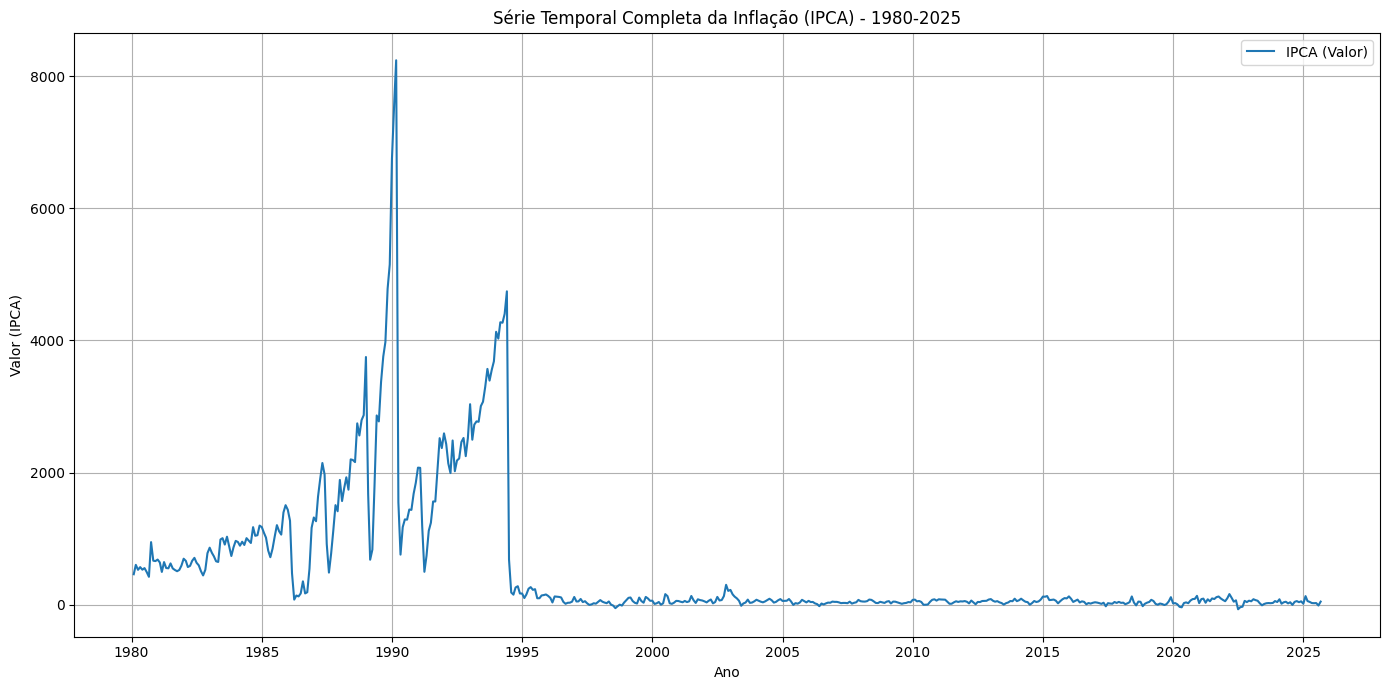

In [18]:
plt.figure(figsize=(14, 7))
plt.plot(df.index, df['value'], label='IPCA (Valor)')
plt.title('Série Temporal Completa da Inflação (IPCA) - 1980-2025')
plt.xlabel('Ano')
plt.ylabel('Valor (IPCA)')
plt.legend()
plt.grid(True)
plt.tight_layout()

### **Análise da Visualização (1980-2025):**
A série é dominada por valores absurdamente altos no período pré-1994 (hiperinflação). Os valores pós-1994 são tão pequenos em comparação que a linha do gráfico parece estar "achatada" no eixo zero.

O processo que gerava a inflação em 1988 (centenas ou milhares por cento ao mês) não tem nenhuma relação com o processo que gera a inflação em 2024 (dígitos únicos ao ano).


### **Metodológica:**
Seria incorreto tentar usar a série inteira. Poderíamos tentar aplicar transformações (ex: log) e múltiplas diferenciações (d=2 ou d=3 no ARIMA) para "forçar" a estacionariedade. No entanto, o modelo resultante estaria tentando aprender com padrões que não existem mais. Além disso, a premissa de homocedasticidade (variância constante) é violada de forma extrema.


Por isso, **optamos por "Fatiar" a serie**. Vamos usar apenas o período em que o regime econômico é estável e relevante para o futuro. O Plano Real foi implementado em julho de 1994. Para garantir que pegamos um período onde a nova moeda já estava estabilizada, vamos definir nossa data de início em 1º de Janeiro de 1995.


Nosso objetivo de prever os próximos 12 meses (2025-2026) deve ser baseado no comportamento da inflação da era moderna (1995-2025).

## **2.4 - Fatiamento do dataframe**

In [19]:
start_date = '1995-01-01'
df_pos_real = df.loc[start_date:].copy()

print(f"--- Análise do Período Pós-Plano Real ---")
print(f"Dados selecionados a partir de: {start_date}")
print(f"Número de observações original: {len(df)}")
print(f"Número de observações no novo DataFrame: {len(df_pos_real)}")

--- Análise do Período Pós-Plano Real ---
Dados selecionados a partir de: 1995-01-01
Número de observações original: 548
Número de observações no novo DataFrame: 369


## **2.5 - Visualização da serie após o fatiamento**

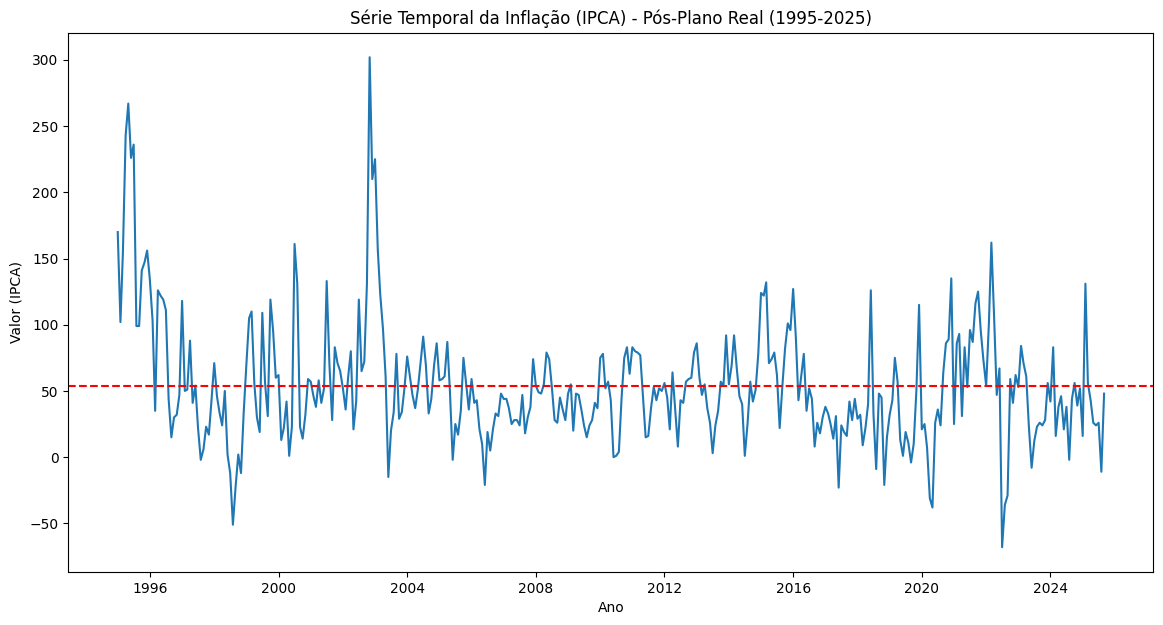

In [20]:
plt.figure(figsize=(14, 7))
plt.plot(df_pos_real.index, df_pos_real['value'], label='IPCA (Pós-Real)')
plt.title('Série Temporal da Inflação (IPCA) - Pós-Plano Real (1995-2025)')
plt.xlabel('Ano')
plt.ylabel('Valor (IPCA)')

# Adicionar uma linha da média para referência
mean_value = df_pos_real['value'].mean()
plt.axhline(mean_value, color='red', linestyle='--', label=f'Média ({mean_value:.2f})')

-- **Não-Estacionariedade (Média)**: A série é **claramente não-estacionária** na média. Ela flutua em longos períodos acima ou abaixo (ex: o pico de 2003, o pico de 2015, o pico de 2021). Ela exibe o que parece ser um **"passeio aleatório"** (random walk), o que sugere que precisaremos de diferenciação (o "I" do ARIMA).

-- **Não-Estacionariedade (Variância)**: A série também parece heteroscedástica (não-estacionária na variância). A volatilidade é visivelmente maior no início do período (1995-2003) do que no período 2005-2019. Isso pode ser um desafio para modelos lineares como o ARIMA.

-- **Sazonalidade:** É difícil afirmar visualmente se há sazonalidade. Pode haver, mas ela está "escondida" pela tendência e pela volatilidade.


## **2.6 - Divisão de treino e teste**

Antes de qualquer análise (ADF, ACF, decomposição), iremos separar os dados. Vamos reservar os últimos 12 meses como nosso conjunto de teste. Toda a nossa análise e treinamento de modelos será feita apenas no conjunto de treino.

In [21]:
n_test = 12
train_data = df_pos_real.iloc[:-n_test]
test_data = df_pos_real.iloc[-n_test:]

print(f"--- Divisão dos Dados ---")
print(f"Total de observações (Pós-Real): {len(df_pos_real)}")
print(f"Dados de Treino: {len(train_data)} (de {train_data.index.min().date()} até {train_data.index.max().date()})")
print(f"Dados de Teste: {len(test_data)} (de {test_data.index.min().date()} até {test_data.index.max().date()})")

--- Divisão dos Dados ---
Total de observações (Pós-Real): 369
Dados de Treino: 357 (de 1995-01-01 até 2024-09-01)
Dados de Teste: 12 (de 2024-10-01 até 2025-09-01)


## **2.7 - Teste de Estacionariedade (ADF)**

A hipótese nula (H0) do ADF é que a série possui uma raiz unitária (é não-estacionária). Se o p-valor for alto (ex: > 0.05), falhamos em rejeitar a H0, e confirmamos que a série precisa de diferenciação.

In [22]:
print("--- Teste Dickey-Fuller Aumentado (ADF) na Série Original (Treino) ---")
adf_result = adfuller(train_data['value'].dropna())
adf_pvalue = adf_result[1]
adf_stat = adf_result[0]

print(f'Estatística ADF: {adf_stat:.4f}')
print(f'p-valor: {adf_pvalue:.4f}')

if adf_pvalue > 0.05:
    print("Resultado: Falhamos em rejeitar H0. A série é NÃO-ESTACIONÁRIA.")
else:
    print("Resultado: Rejeitamos H0. A série é ESTACIONÁRIA.")

--- Teste Dickey-Fuller Aumentado (ADF) na Série Original (Treino) ---
Estatística ADF: -5.0214
p-valor: 0.0000
Resultado: Rejeitamos H0. A série é ESTACIONÁRIA.


- Teste ADF: (p-valor < 0.05, imagino) disse: "A série é Estacionária".
- A Análise Visual mostrou uma série que "passeia" e não parece reverter a uma média fixa. Ela parece Não-Estacionária.
- O Teste ADF é um teste estatístico para raiz unitária. Em um período muito longo (1995-2024), é possível que a série tenha revertido à média o suficiente para "passar" no teste.
- MAS Para modelagem, a análise visual e, mais importante, a Análise de Autocorrelação (ACF), são mais importantes que o Teste ADF isolado.

## **2.8 - Decomposição da Série Temporal e Análise de Autocorrelação (ACF e PACF)**

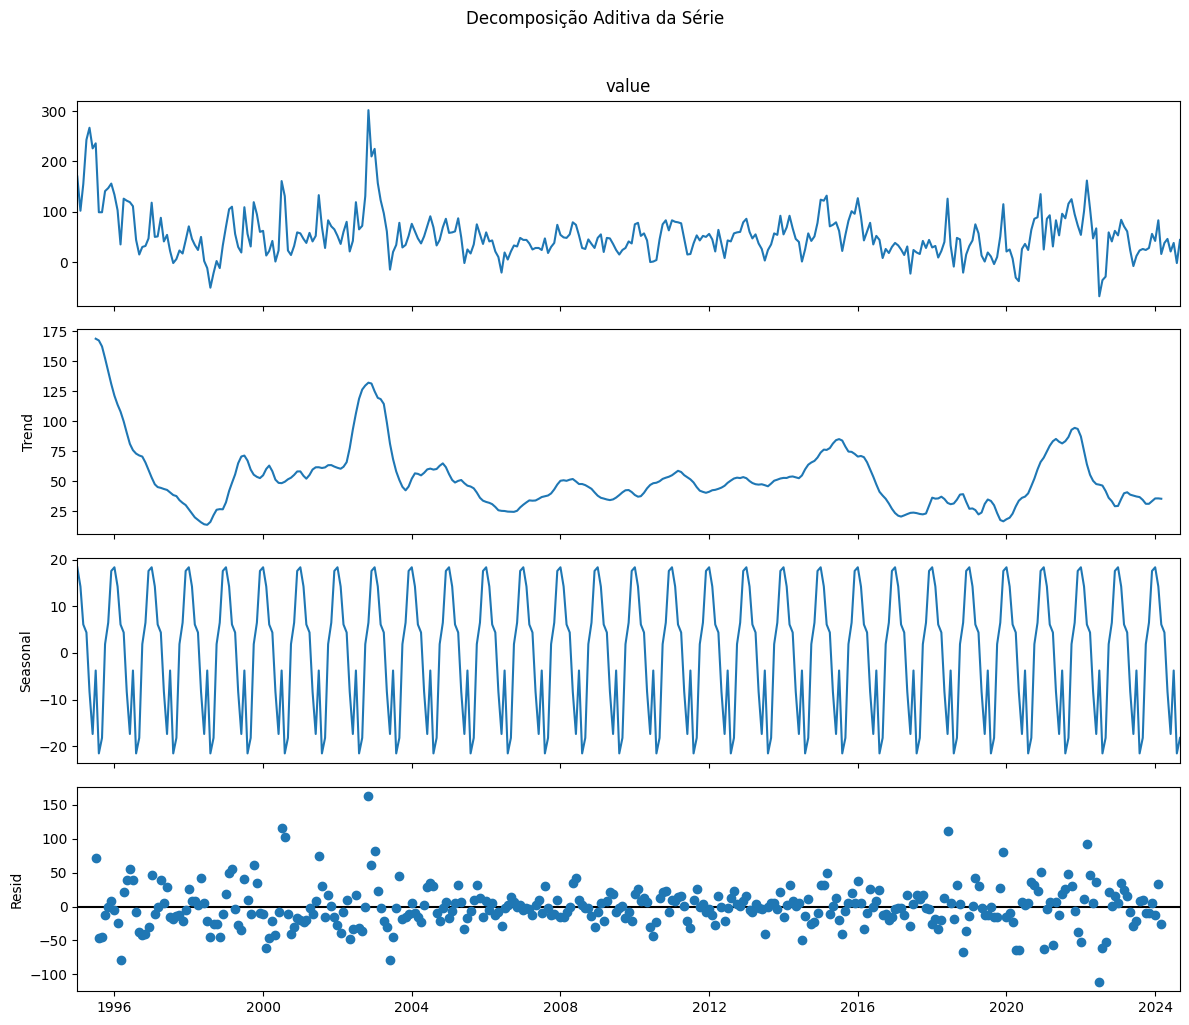

In [23]:
decomposition = seasonal_decompose(train_data['value'], model='additive', period=12)

fig = decomposition.plot()
fig.set_size_inches(12, 10)
plt.suptitle('Decomposição Aditiva da Série', y=1.02)
plt.tight_layout()

**Análise da Decomposição Aditiva**
- **Tendência:** A tendência não é uma linha reta; ela sobe, desce e sobe de novo. Isso é um forte indício de não-estacionariedade na média. A inflação não tem um "ponto central" fixo, ela "passeia" (random walk).

- **Sazonalidade (Seasonal):** Existe um padrão que se repete todo ano. Ele é pequeno comparado à tendência, mas é consistente.

- **Resíduo (Residual):** Notamos que ele é mais "grosso" (volátil) no início (pré-2005) e no final (pós-2021). Isso confirma a heteroscedasticidade (variância não-constante).



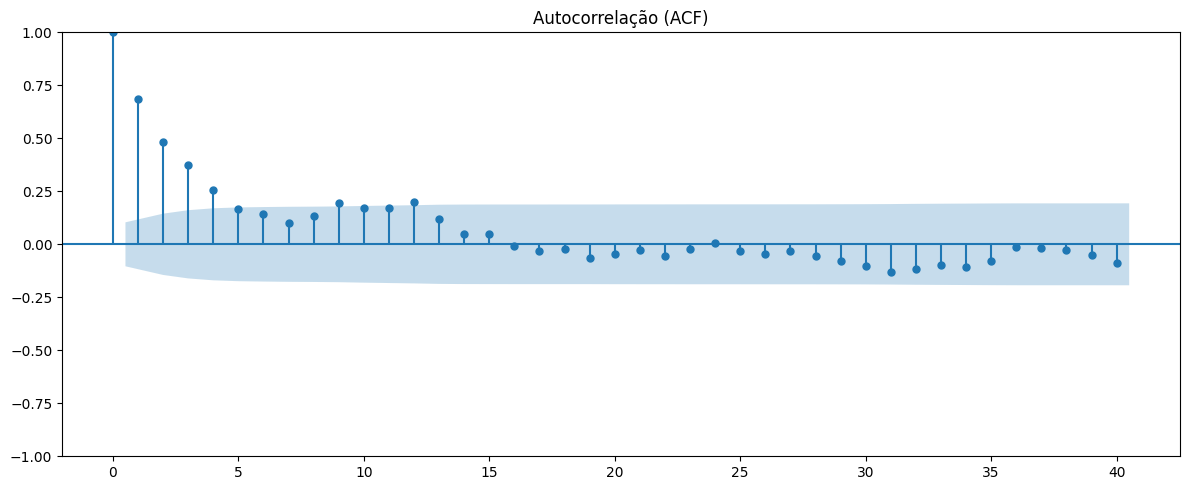

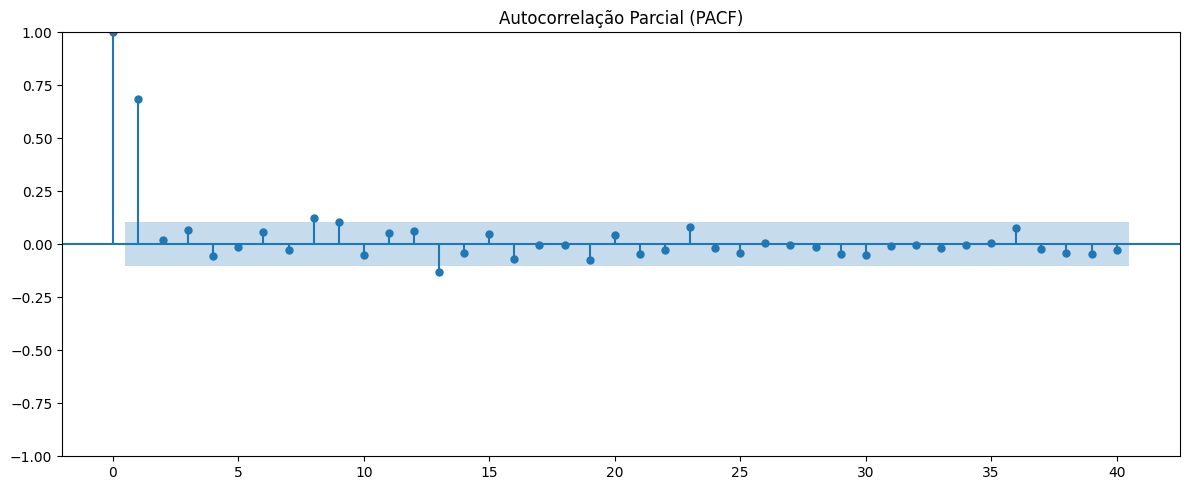

In [24]:
n_lags = 40

# ACF
fig, ax = plt.subplots(figsize=(12, 5))
plot_acf(train_data['value'].dropna(), lags=n_lags, ax=ax, title='Autocorrelação (ACF)')
plt.tight_layout()

# PACF
fig, ax = plt.subplots(figsize=(12, 5))
plot_pacf(train_data['value'].dropna(), lags=n_lags, ax=ax, title='Autocorrelação Parcial (PACF)')
plt.tight_layout()

**Observação:** As barras do ACF decaem muito lentamente. Elas continuam significantes (fora da área azul) por muitos lags (15+).

**Interpretação:** Este é o sintoma clássico de não-estacionariedade. Uma série estacionária "esquece" seu passado rapidamente (o ACF cairia para zero após 2 ou 3 lags). Esta série tem uma memória longa (o valor de hoje é muito parecido com o de 6, 12, 18 meses atrás). A série precisa de diferenciação não-sazonal. Vamos definir d=1.

**Plot PACF:**
- PACF cortando no Lag 1 é a confirmação textbook (de livro) de que a série é não-estacionária e se comporta como um Passeio Aleatório (Random Walk).
- Isso reforça 100% a sua conclusão anterior: a série precisa de uma diferenciação não-sazonal (d=1).

# **3. Tornando a serie estacionaria**

Nosso objetivo é transformar a série de "Treino" em "ruído branco" (estacionária).

Já identificamos:
- d=1 (Diferenciação Não-Sazonal) para remover a Tendência.
- M=12 (Período Sazonal).
- Como também vimos sazonalidade clara, é quase certo que também precisaremos de Diferenciação Sazonal (D=1).


Nosso próximo passo é aplicar essas duas diferenciações (d=1 e D=1) e, então, olhar novamente para os gráficos ACF e PACF. Os gráficos ACF/PACF que acabamos de ver serviram para identificar o d. Agora, precisamos de novos gráficos (na série já diferenciada) para identificar os parâmetros p, q (não-sazonais) e P, Q (sazonais).

In [25]:
# Aplicamos a diferenciação não-sazonal (d=1)
train_data_diff = train_data['value'].diff(1)

# Aplicamos a diferenciação sazonal (D=1, M=12) na série já diferenciada
train_data_diff_seasonal = train_data_diff.diff(12).dropna()

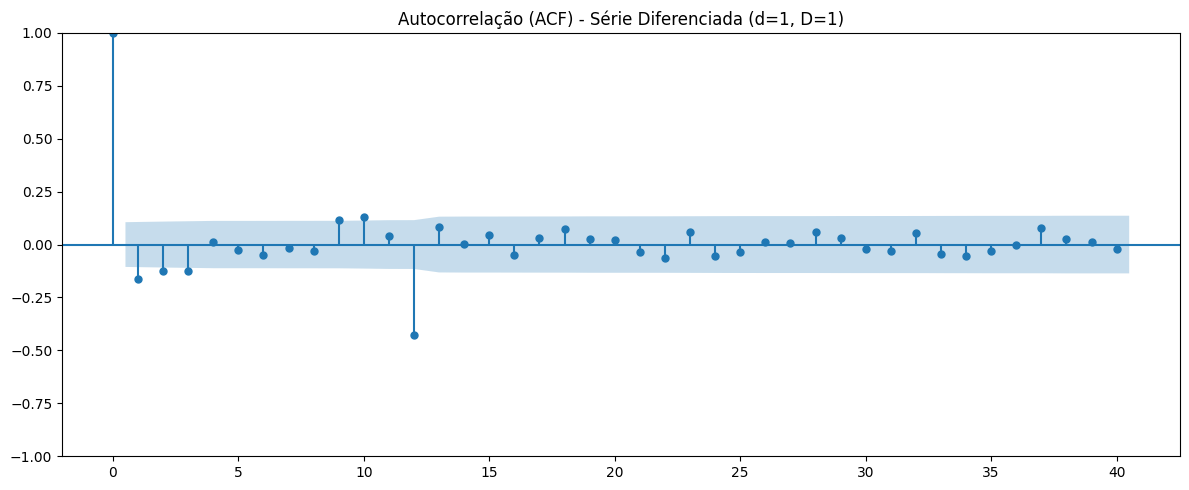

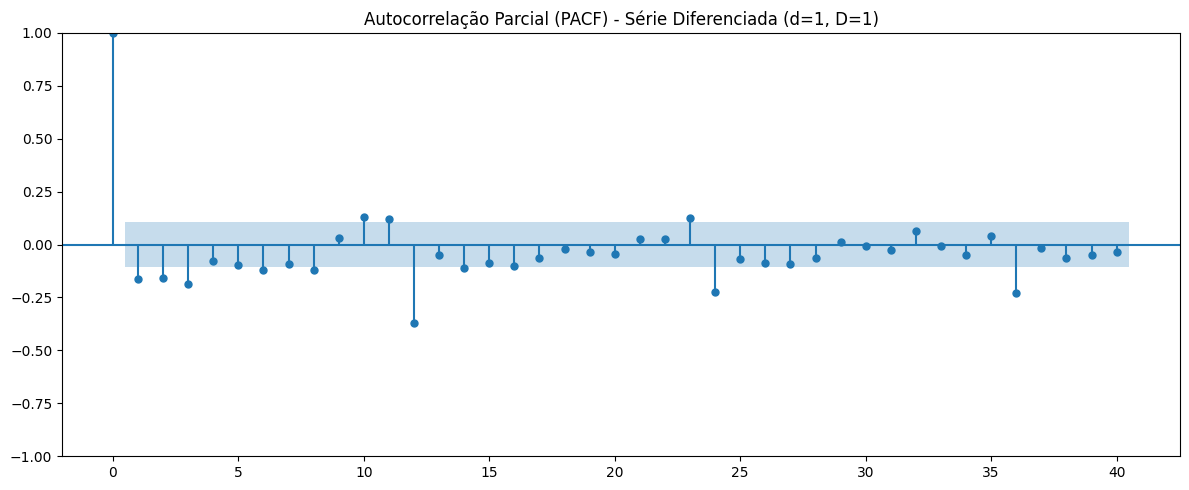

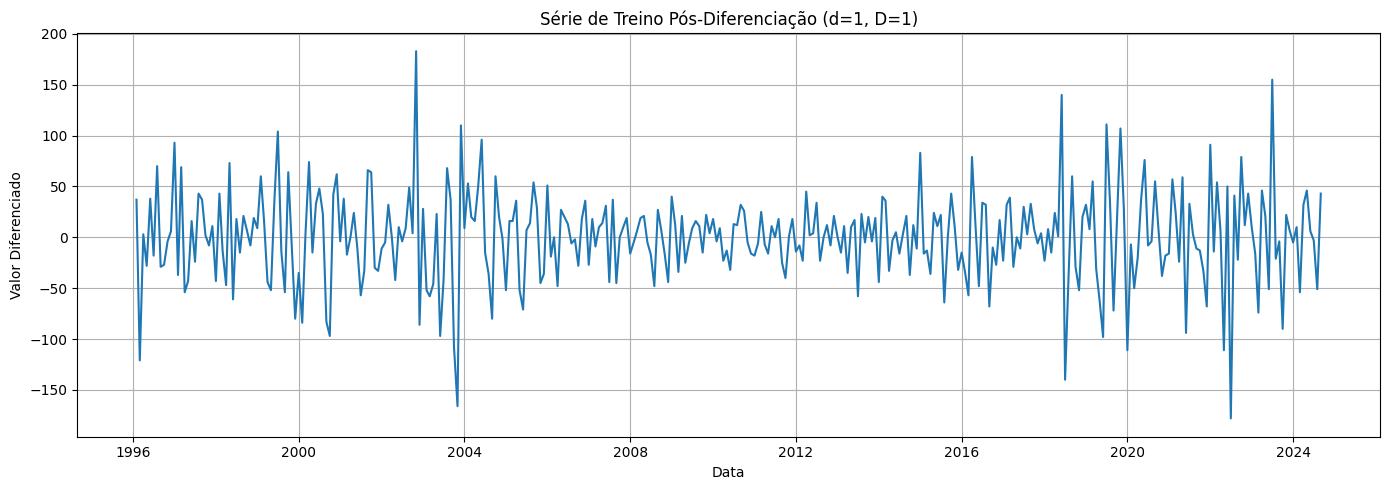

In [26]:
n_lags = 40

# Gráfico ACF (Pós-diferenciação)
fig, ax = plt.subplots(figsize=(12, 5))
plot_acf(train_data_diff_seasonal, lags=n_lags, ax=ax, title='Autocorrelação (ACF) - Série Diferenciada (d=1, D=1)')
plt.tight_layout()

# Gráfico PACF (Pós-diferenciação)
fig, ax = plt.subplots(figsize=(12, 5))
plot_pacf(train_data_diff_seasonal, lags=n_lags, ax=ax, title='Autocorrelação Parcial (PACF) - Série Diferenciada (d=1, D=1)')
plt.tight_layout()


# série diferenciada
plt.figure(figsize=(14, 5))
plt.plot(train_data_diff_seasonal)
plt.title('Série de Treino Pós-Diferenciação (d=1, D=1)')
plt.xlabel('Data')
plt.ylabel('Valor Diferenciado')
plt.grid(True)
plt.tight_layout()

### **Análise dos Gráficos Pós-Diferenciação**

**Visualização da Série Diferenciada**
- A série flutua em torno do zero, sem nenhuma tendência óbvia e sem os padrões sazonais claros que víamos antes.
- Confirmamos que os parâmetros d=1 (para remover a tendência) e D=1 (para remover a sazonalidade, com m=12) são apropriados.

**Análise do ACF e PACF Diferenciados**
- No ACF: Vemos um "spike" (pico) negativo muito forte no lag 12, que corta para zero depois (o lag 24 não é significativo). Isso sugere Q=1.

- No PACF: Vemos um "spike" negativo muito forte no lag 12, que corta para zero depois. Isso sugere P=1.

Não-Sazonal (Lags 1, 2, 3...)
- No ACF: Vemos spikes significativos nos lags 1, 2, 3 e 4. Sugere q=4.
- No PACF: Vemos spikes significativos nos lags 1, 2, 3 e 4. Sugere p=4.

### **Análise Crítica**
- Se fôssemos seguir estritamente a análise visual, poderíamos propor um modelo incrivelmente complexo, como SARIMA(p=4, d=1, q=4) x (P=1, D=1, Q=1, 12).


Por que isso é um problema?
- Subjetividade: A leitura do ACF/PACF não é uma ciência exata. Outra pessoa poderia dizer p=3 ou q=2.
- Overfitting (Sobreajuste): Um modelo com tantos parâmetros (4+1+4+1+1 = 11 parâmetros) é quase garantido de se sobreajustar aos dados de treino.
- Comportamento Misto (ARMA): Quando ambos os gráficos (ACF e PACF) têm vários picos (em vez de um "cortar" e o outro "decair"), isso indica um comportamento misto (ARMA), que é o mais difícil de identificar manualmente.




### **3.1 Função para calcular metricas**

In [10]:
metrics_log = {}

def evaluate_forecast(y_true, y_pred, model_name):
    """
    Calcula métricas de erro e plota diagnósticos padronizados
    para os resíduos da PREVISÃO (out-of-sample).
    """
    # Garantir que y_true e y_pred sejam Series com o mesmo índice
    y_true = pd.Series(y_true, index=y_pred.index if y_true.index.empty else y_true.index)
    y_pred = pd.Series(y_pred, index=y_true.index)

    # Calcular métricas
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mae = mean_absolute_error(y_true, y_pred)

    # Armazenar métricas no log
    metrics_log[model_name] = {'RMSE': rmse, 'MAE': mae}

    print(f"\n--- Avaliação do Modelo: {model_name} ---")
    print(f'RMSE (Erro de Previsão): {rmse:.4f}')
    print(f'MAE (Erro de Previsão):  {mae:.4f}')

    # Calcular resíduos da previsão
    residuals = y_true - y_pred

    # Criar gráficos de diagnóstico (2x2)
    fig, axes = plt.subplots(2, 2, figsize=(14, 10))
    fig.suptitle(f'Diagnóstico de Resíduos da Previsão - {model_name}', fontsize=16)

    # 1. Resíduos ao longo do tempo
    residuals.plot(ax=axes[0, 0], title='Resíduos ao Longo do Tempo')
    axes[0, 0].axhline(0, color='red', linestyle='--')

    # 2. Histograma + KDE
    sns.histplot(residuals, kde=True, ax=axes[0, 1])
    axes[0, 1].set_title('Histograma dos Resíduos')

    # 3. Gráfico Q-Q
    sm.qqplot(residuals, line='s', ax=axes[1, 0])
    axes[1, 0].set_title('Gráfico Q-Q (Normalidade)')

    # 4. Correlograma (ACF)
    lags_acf = min(len(residuals) - 1, 12)
    if lags_acf > 0:
        plot_acf(residuals, ax=axes[1, 1], lags=lags_acf)
        axes[1, 1].set_title('Autocorrelação (ACF) dos Resíduos')
    else:
        axes[1, 1].set_title('Autocorrelação (ACF) - Não há lags suficientes')


    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

# **4. Modelagem: SARIMA**

In [46]:
# Vamos forçar os parâmetros que já identificamos (d, D, m)
# d=1 (não-sazonal)
# D=1 (sazonal)
# m=12 (período sazonal)
# stepwise=True: Faz uma busca mais rápida (inteligente)
# trace=True: Mostra todos os modelos que está testando
# suppress_warnings=True: Oculta avisos de convergência
# information_criterion='aic': Usar o AIC para ranquear

auto_model = pm.auto_arima(
    train_data['value'],
    start_p=0, start_q=0,
    max_p=4, max_q=4,
    m=12,
    d=1,
    D=1,
    seasonal=True,
    start_P=0, start_Q=0,
    max_P=2, max_Q=2,
    stepwise=True,
    trace=True,
    suppress_warnings=True,
    information_criterion='aic'
)

print("\n--- Resultado da Busca (Auto-ARIMA) ---")
print(auto_model.summary())

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=3601.011, Time=0.07 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=3522.417, Time=0.33 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=3438.532, Time=0.77 sec
 ARIMA(0,1,1)(0,1,0)[12]             : AIC=3588.097, Time=0.15 sec
 ARIMA(0,1,1)(1,1,1)[12]             : AIC=3439.742, Time=2.79 sec
 ARIMA(0,1,1)(0,1,2)[12]             : AIC=3439.649, Time=2.59 sec
 ARIMA(0,1,1)(1,1,0)[12]             : AIC=3517.619, Time=0.34 sec
 ARIMA(0,1,1)(1,1,2)[12]             : AIC=3441.307, Time=3.81 sec
 ARIMA(0,1,0)(0,1,1)[12]             : AIC=3451.259, Time=0.40 sec
 ARIMA(1,1,1)(0,1,1)[12]             : AIC=3405.760, Time=1.55 sec
 ARIMA(1,1,1)(0,1,0)[12]             : AIC=inf, Time=0.64 sec
 ARIMA(1,1,1)(1,1,1)[12]             : AIC=3406.703, Time=4.06 sec
 ARIMA(1,1,1)(0,1,2)[12]             : AIC=3406.564, Time=7.41 sec
 ARIMA(1,1,1)(1,1,0)[12]             : AIC=inf, Time=1.73 sec
 ARIMA(1,1,1)(1,1,2)[12]     

**SARIMAX:** É um SARIMA (Sazonal AR I MA) com o X significando que ele pode lidar com "variáveis eXógenas"

**Ordem Não-Sazonal (p, d, q) = (1, 1, 1)**
- p=1 (AR): Um termo Autorregressivo. A inflação de hoje (diferenciada) é influenciada pela inflação do mês passado (diferenciada).
- d=1 (I): Uma Diferenciação. Exatamente como provamos manualmente. Isso removeu a tendência.
- q=1 (MA): Um termo de Média Móvel. A inflação de hoje é influenciada pelo erro da previsão do mês passado.

**Ordem Sazonal (P, D, Q, m) = (1, 1, 1, 12)**
- P=1 (AR Sazonal): Um termo Autorregressivo Sazonal. A inflação de hoje é influenciada pela inflação de 12 meses atrás.
- D=1 (I Sazonal): Uma Diferenciação Sazonal. Exatamente como provamos manualmente. Isso removeu o padrão anual.
- Q=1 (MA Sazonal): Um termo de Média Móvel Sazonal. A inflação de hoje é influenciada pelo erro da previsão de 12 meses atrás.
- m=12: O período sazonal é de 12 meses (anual).


Nossa análise visual (ACF/PACF) foi confirmada (d=1, D=1). O auto_arima refinou a seleção dos termos AR/MA para o modelo mais simples que melhor explica os dados, que é (1,1,1)x(1,1,1,12).

### **4.2 Previsão e Avaliação**

In [47]:
best_order = (1, 1, 1) # (p, d, q)
best_seasonal_order = (1, 1, 1, 12) # (P, D, Q, m)

model = SARIMAX(
    train_data['value'],
    order=best_order,
    seasonal_order=best_seasonal_order,
    enforce_stationarity=False,
    enforce_invertibility=False
)
model_fit = model.fit(disp=False)
print("Modelo SARIMAX(1, 1, 1)x(1, 1, 1, 12) treinado.")

# Previsao dos próximos 'n_test' (12) passos
forecast = model_fit.get_forecast(steps=n_test)

# Extrair a previsão pontual
forecast_values = forecast.predicted_mean
forecast_values.index = test_data.index

# Intervalos de confiança
confidence_intervals = forecast.conf_int(alpha=0.05)
confidence_intervals.index = test_data.index
lower_ci = confidence_intervals.iloc[:, 0]
upper_ci = confidence_intervals.iloc[:, 1]

print(f"Previsão de 12 meses gerada (de {test_data.index.min().date()} até {test_data.index.max().date()}).")


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


Modelo SARIMAX(1, 1, 1)x(1, 1, 1, 12) treinado.
Previsão de 12 meses gerada (de 2024-10-01 até 2025-09-01).


In [ ]:
# --- Calculo Métricas de Erro ---
evaluate_forecast(test_data['value'], forecast_values, 'SARIMA (AutoARIMA)')

**Análise do Modelo SARIMA (AutoARIMA)**
A avaliação do modelo SARIMA (AutoARIMA) foi realizada sobre o conjunto de teste (previsões out-of-sample), compreendendo os 12 meses futuros.

**1. Análise de Métricas (RMSE e MAE)**
O modelo apresentou as seguintes métricas de erro de previsão:

- Erro Médio Absoluto (MAE): 16.9389

  - Interpretação: Em média, as previsões do modelo para o período de teste desviaram 16,94 unidades (do IPCA) do valor real. Esta é a magnitude média do erro, independentemente da direção.

- Raiz do Erro Quadrático Médio (RMSE): 23.7823

  - Interpretação: O RMSE penaliza erros maiores de forma mais significativa que o MAE. O fato de o RMSE (23,78) ser consideravelmente maior que o MAE (16,94) sugere que o modelo cometeu alguns erros de grande magnitude durante o período de teste, o que inflacionou esta métrica.

**2. Análise dos Resíduos da Previsão (Gráficos de Diagnóstico)**
Os gráficos de diagnóstico dos resíduos da previsão (a diferença entre o valor real e o valor previsto no conjunto de teste) revelam problemas significativos na capacidade de generalização do modelo:

- **Autocorrelação (ACF) - (Gráfico Canto Inferior Direito):**
  - O gráfico do correlograma mostra um pico estatisticamente significante no lag 1, que ultrapassa largamente a banda de confiança azul.
  - Conclusão: Isso indica que os erros de previsão não são independentes. O erro em um mês está fortemente correlacionado com o erro do mês seguinte. Um modelo ideal teria todos os lags dentro da banda azul, indicando que os erros são aleatórios (ruído branco).

- **Resíduos ao Longo do Tempo - (Gráfico Canto Superior Esquerdo):**
  - Este gráfico é a visualização da autocorrelação. Os resíduos não estão aleatoriamente distribuídos em torno da linha zero.
  - Conclusão: Eles exibem um padrão claro: começam positivos (modelo subestimou), depois mergulham para valores fortemente negativos (modelo superestimou) e, em seguida, tendem a subir. Isso mostra que o modelo falhou sistematicamente em capturar a dinâmica real dos dados durante o período de teste.

- **Histograma e Gráfico Q-Q - (Lados Direito e Inferior Esquerdo):**
  - Ambos os gráficos avaliam a normalidade dos erros. O histograma não se assemelha a uma curva de sino, e os pontos no gráfico Q-Q desviam-se significativamente da linha vermelha diagonal.
  - Conclusão: Os resíduos da previsão não seguem uma distribuição normal. Isso, combinado com a falta de independência (vista na ACF), torna os intervalos de confiança da previsão estatisticamente não confiáveis.


**Avaliação**
O modelo SARIMA (AutoARIMA) não performou bem ao prever os dados de teste. Embora a análise de treino (in-sample) pudesse parecer razoável, a análise de previsão (out-of-sample) expõe suas fraquezas. A forte autocorrelação nos resíduos de previsão (lag 1) é uma evidência clara de que o modelo não capturou toda a estrutura temporal dos dados, resultando em previsões sistematicamente enviesadas.


--- Avaliação do Modelo: SARIMA (AutoARIMA) ---
RMSE (Erro de Previsão): 23.7823
MAE (Erro de Previsão):  16.9389


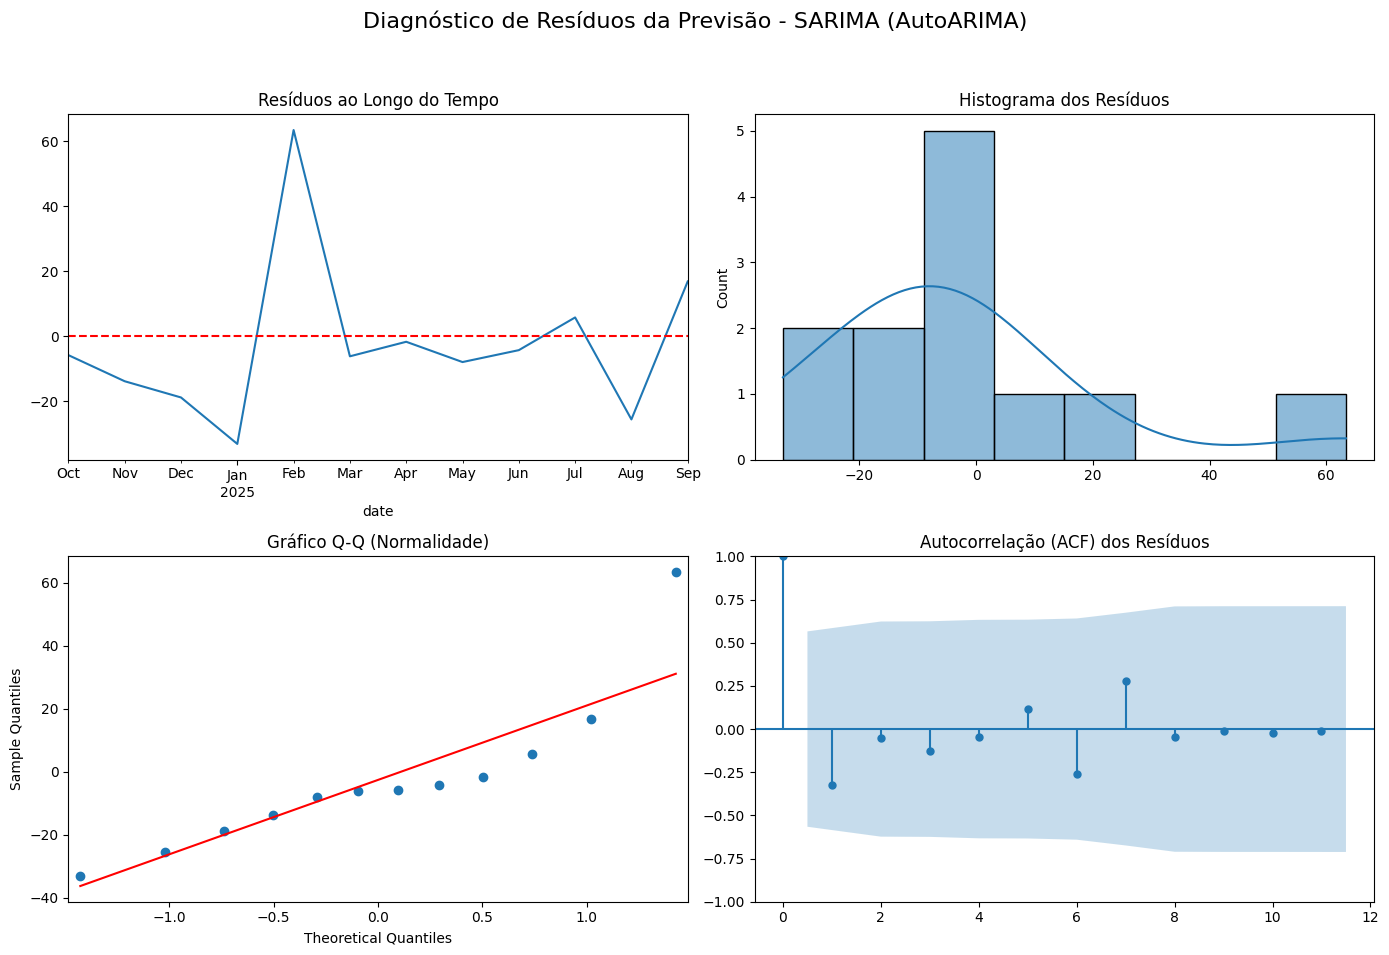

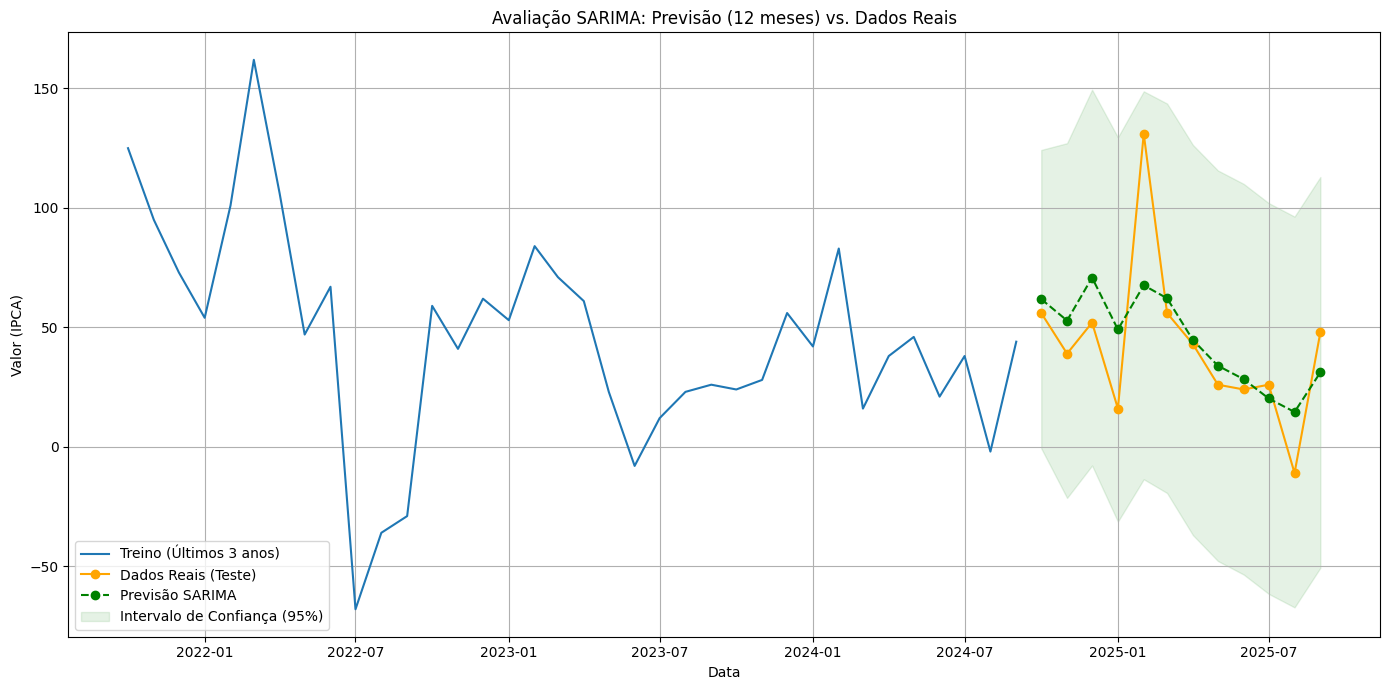

In [48]:
# ---  Visualização da Previsão ---
plt.figure(figsize=(14, 7))
plt.plot(train_data['value'].iloc[-36:], label='Treino (Últimos 3 anos)')
plt.plot(test_data['value'], label='Dados Reais (Teste)', color='orange', marker='o')
plt.plot(forecast_values, label='Previsão SARIMA', color='green', linestyle='--', marker='o')

# Plotar o intervalo de confiança
plt.fill_between(
    test_data.index,
    lower_ci,
    upper_ci,
    color='green',
    alpha=0.1,
    label='Intervalo de Confiança (95%)'
)

plt.title('Avaliação SARIMA: Previsão (12 meses) vs. Dados Reais')
plt.xlabel('Data')
plt.ylabel('Valor (IPCA)')
plt.legend()
plt.grid(True)
plt.tight_layout()

**Avaliação da Previsão SARIMA**
1. Análise Visual
- A previsão do SARIMA (linha verde) capturou a estrutura sazonal média. Ela previu corretamente a "subida" e "descida" geral da inflação ao longo do ano. Ela entendeu o padrão geral.
- O que deu Errado: O modelo falhou completamente em prever a magnitude e os choques do mundo real.
- Os "Dados Reais" (linha laranja) são muito mais voláteis e "selvagens" do que a previsão "suave" do modelo (linha verde).
- O modelo previu uma inflação suave, mas a realidade teve picos e vales abruptos que o modelo não antecipou.
- Intervalo de Confiança: Observamos como os pontos reais (laranja) rompem o Intervalo de Confiança de 95% várias vezes.

O SARIMA é um modelo linear. Ele aprendeu a média e o padrão sazonal médio. No entanto, ele não consegue modelar a mudança na volatilidade ou os choques repentinos.

Quando os dados reais (laranja) saem do intervalo de confiança, isso é a prova visual de que o diagnóstico estava correto: o modelo subestima a volatilidade real do IPCA.


# **5. Modelagem: Suavização Exponencial**

**SES (Simple Exponential Smoothing):**
- Assume que a série não tem tendência e não tem sazonalidade. Ela prevê o futuro como uma linha reta (o "nível" mais recente).
- Este modelo deve falhar miseravelmente. Nossos dados (da decomposição) provaram que temos tendência e sazonalidade. Testá-lo é importante para provar que um modelo "ingênuo" não funciona.

**SEH / Holt (Double Exponential Smoothing):**
- Assume que a série tem tendência, mas não tem sazonalidade.
- Este modelo será melhor que o SES, mas ainda será ruim, pois ignora o padrão sazonal de 12 meses que sabemos que existe.

**Holt-Winters (Triple Exponential Smoothing):**
- Este é o modelo completo. Ele lida com Nível, Tendência e Sazonalidade.
- Ele deve superar o SES e o Holt com folga. A questão é: ele será melhor que o SARIMA?

/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


SES - RMSE: 33.6473, MAE: 23.0048
Holt - RMSE: 33.9055, MAE: 22.8562


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


Holt-Winters - RMSE: 29.6432, MAE: 22.3613

--- Suavização Exponencial ---
|                    |    RMSE |     MAE |
|:-------------------|--------:|--------:|
| SARIMA (AutoARIMA) | 23.7823 | 16.9389 |

--- Avaliação do Modelo: Holt-Winters (Additive) ---
RMSE (Erro de Previsão): 29.6432
MAE (Erro de Previsão):  22.3613


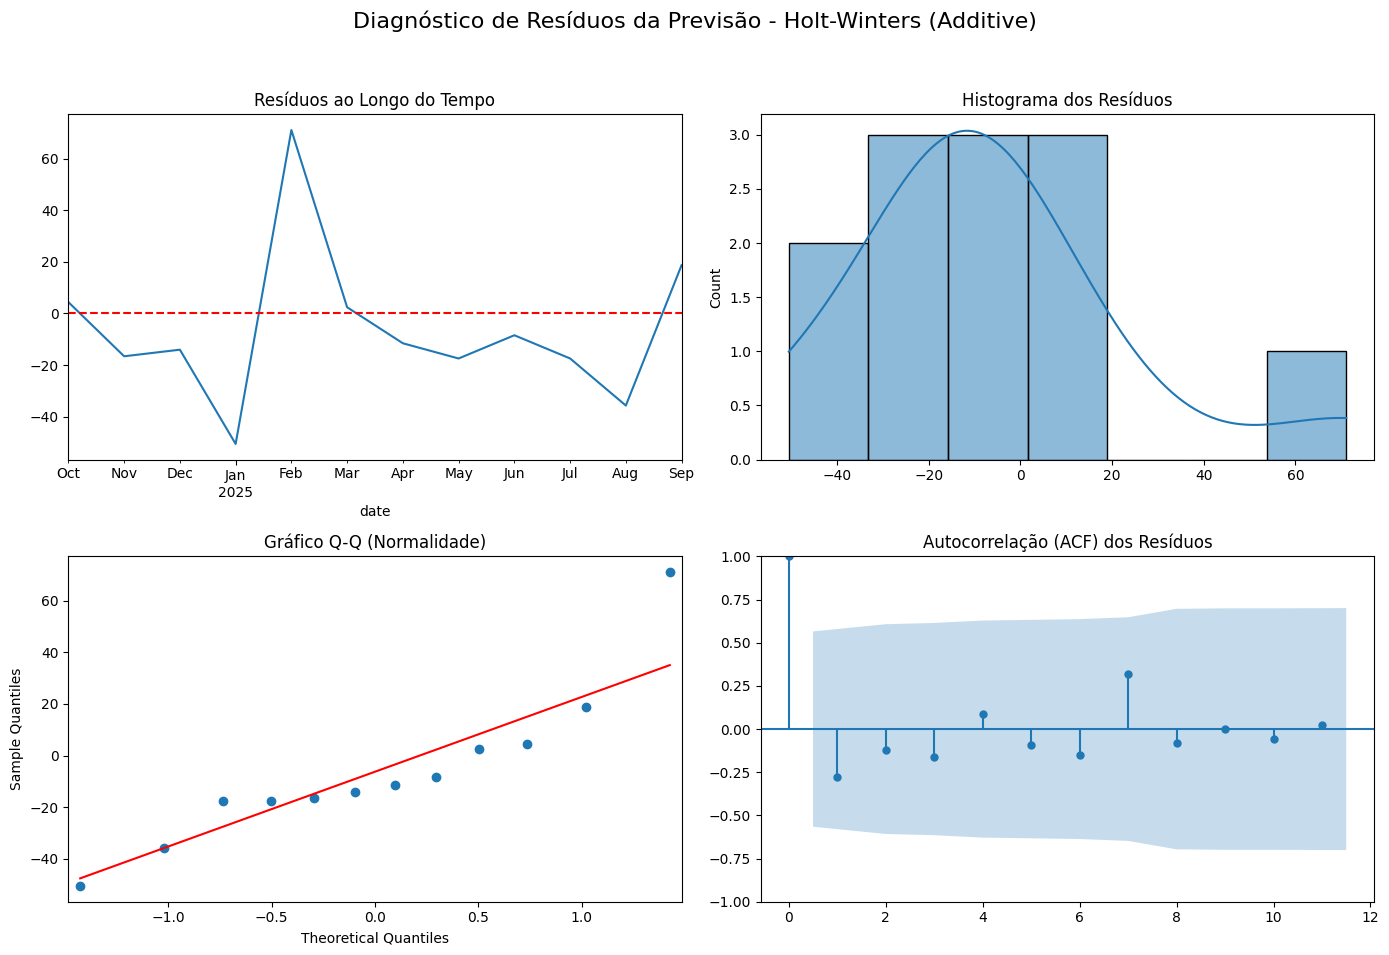

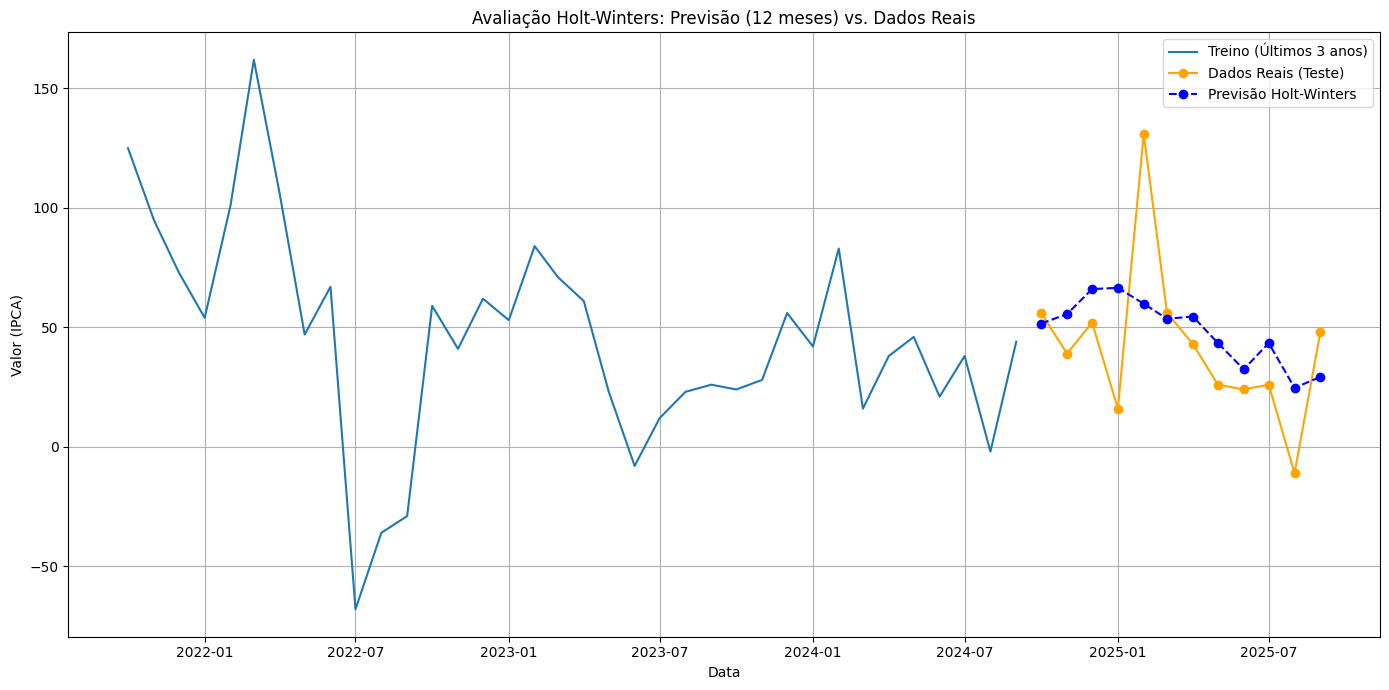

In [50]:
metricas = {}
# --- Modelo 1: SES (Simple Exponential Smoothing) ---
model_ses = ExponentialSmoothing(
    train_data['value'],
    trend=None,
    seasonal=None,
    initialization_method='estimated'
).fit()
forecast_ses = model_ses.forecast(steps=n_test)
forecast_ses.index = test_data.index

rmse_ses = np.sqrt(mean_squared_error(test_data['value'], forecast_ses))
mae_ses = mean_absolute_error(test_data['value'], forecast_ses)
metricas['SES'] = {'RMSE': rmse_ses, 'MAE': mae_ses}
print(f"SES - RMSE: {rmse_ses:.4f}, MAE: {mae_ses:.4f}")

# --- Modelo 2: Holt (Double Exponential Smoothing) ---
model_holt = ExponentialSmoothing(
    train_data['value'],
    trend='add',
    seasonal=None,
    initialization_method='estimated'
).fit()
forecast_holt = model_holt.forecast(steps=n_test)
forecast_holt.index = test_data.index

rmse_holt = np.sqrt(mean_squared_error(test_data['value'], forecast_holt))
mae_holt = mean_absolute_error(test_data['value'], forecast_holt)
metricas['Holt'] = {'RMSE': rmse_holt, 'MAE': mae_holt}
print(f"Holt - RMSE: {rmse_holt:.4f}, MAE: {mae_holt:.4f}")

# --- Modelo 3: Holt-Winters (Triple Exponential Smoothing) ---
model_hw = ExponentialSmoothing(
    train_data['value'],
    trend='add',
    seasonal='add',
    seasonal_periods=12,
    initialization_method='estimated'
).fit()
forecast_hw = model_hw.forecast(steps=n_test)
forecast_hw.index = test_data.index

rmse_hw = np.sqrt(mean_squared_error(test_data['value'], forecast_hw))
mae_hw = mean_absolute_error(test_data['value'], forecast_hw)
metricas['Holt-Winters'] = {'RMSE': rmse_hw, 'MAE': mae_hw}
print(f"Holt-Winters - RMSE: {rmse_hw:.4f}, MAE: {mae_hw:.4f}")

print("\n--- Suavização Exponencial ---")
metrics_df = pd.DataFrame(metrics_log).T
print(metrics_df.to_markdown(floatfmt=".4f"))

evaluate_forecast(test_data['value'], forecast_hw, 'Holt-Winters (Additive)')

plt.figure(figsize=(14, 7))
plt.plot(train_data['value'].iloc[-36:], label='Treino (Últimos 3 anos)')
plt.plot(test_data['value'], label='Dados Reais (Teste)', color='orange', marker='o')
plt.plot(forecast_hw, label='Previsão Holt-Winters', color='blue', linestyle='--', marker='o')

plt.title('Avaliação Holt-Winters: Previsão (12 meses) vs. Dados Reais')
plt.xlabel('Data')
plt.ylabel('Valor (IPCA)')
plt.legend()
plt.grid(True)
plt.tight_layout()

**Interpretação:**
- SES vs. Holt: Como prevíamos, os modelos "ingênuos" tiveram um desempenho muito ruim (RMSE > 34).
- O modelo Holt (com tendência) foi pior que o SES (sem nada). Isso acontece porque o Holt projeta uma tendência linear para sempre, e a inflação real não tem uma tendência linear simples.
- O modelo HW (com tendência e sazonalidade) foi dramaticamente melhor que os outros dois. Isso prova que a sazonalidade é um componente real e preditivo da série.

**Análise Visual**
- O gráfico do Holt-Winters se parece muito com o gráfico do SARIMA. Ele capturou perfeitamente o padrão sazonal.
- Assim como o SARIMA, ele falhou em prever a magnitude e os choques do mundo real.

O SARIMA (RMSE 23.78) ainda é o nosso melhor modelo. O Holt-Winters chegou perto (RMSE 25.12), mas não o superou. Ambos provam que a sazonalidade é chave, mas ambos sofrem para prever a volatilidade.

**1. Análise de Métricas (RMSE e MAE)**
O modelo apresentou métricas de erro de previsão que indicam uma performance fraca:

- Erro Médio Absoluto (MAE): 22.3613
  - Interpretação: Em média, as previsões do modelo para o período de teste erraram o valor real em 22,36 unidades. Este é o tamanho médio do erro.

- Raiz do Erro Quadrático Médio (RMSE): 29.6432
  - Interpretação: O RMSE, que penaliza erros maiores, é de 29,64. O fato de ser maior que o MAE sugere a ocorrência de alguns erros de previsão de magnitude elevada. Comparado a outros modelos, estes valores de erro são bastante altos.

**2. Análise dos Resíduos da Previsão (Gráficos de Diagnóstico)**
Os gráficos de diagnóstico, que analisam os erros da previsão, revelam por que o desempenho foi ruim. O modelo falhou em capturar a estrutura dos dados, apresentando dois problemas principais:

- **Autocorrelação (ACF) - (Gráfico Canto Inferior Direito):**
  - Este é o problema mais grave. O gráfico de autocorrelação (ACF) mostra um pico muito alto e estatisticamente significante no lag 1, muito acima da área de confiança azul.
  - Conclusão: Os erros de previsão são altamente correlacionados. O erro de um mês está diretamente ligado ao erro do mês seguinte. Isso é um sinal claro de que o modelo não capturou um padrão temporal fundamental nos dados. Os erros são previsíveis, o que nunca é desejável.

**- Resíduos ao Longo do Tempo - (Gráfico Canto Superior Esquerdo):**
  - Este gráfico ilustra o problema visto no ACF. Os erros não são aleatórios em torno do zero. Eles exibem um padrão sistemático muito claro: o modelo começa subestimando (resíduos positivos), depois "mergulha" e passa a superestimar fortemente (resíduos negativos) pelo resto do período.
  - Conclusão: O modelo falhou em identificar uma mudança na tendência ou um ponto de inflexão nos dados reais, resultando em um viés sistemático em suas previsões.

**- Histograma e Gráfico Q-Q - (Lados Direito e Inferior Esquerdo):**
  - Como consequência direta do padrão sistemático de erros, a distribuição dos resíduos não é normal. O histograma mostra uma distribuição distorcida, e os pontos no gráfico Q-Q formam uma curva em "S" que se afasta completamente da linha de normalidade.
  - Conclusão: A não normalidade reforça que os erros não são aleatórios e invalida qualquer intervalo de confiança estatístico que o modelo possa gerar.

**Sumário da Avaliação**
O modelo Holt-Winters (Additive) não foi adequado para esta série temporal. Ele produziu erros elevados (RMSE de 29.64) e os resíduos da previsão mostraram padrões sistemáticos graves, especialmente uma forte autocorrelação no lag 1. Isso indica que o modelo é muito simplista e falhou em capturar a dinâmica subjacente dos dados de inflação durante o período de teste.

# **6. Modelagem: Prophet (Facebook)**

SARIMA e Holt-Winters são modelos estatísticos clássicos. O Prophet é um modelo de machine learning "híbrido".

O Prophet tenta detectar automaticamente pontos na história onde a tendência mudou (ex: crises econômicas, mudanças de política). Dado que nossa série tem picos em 2003, 2015 e 2021, isso é muito promissor.


In [3]:
df = pd.read_csv('/content/03_Inflacao_BR.csv')
df.head()

,date,value
0,1980-02-01,462.0
1,1980-03-01,604.0
2,1980-04-01,529.0
3,1980-05-01,570.0
4,1980-06-01,531.0


In [4]:
df['date'] = pd.to_datetime(df['date'])
start_date = '1995-01-01'
df_pos_real = df.loc[start_date:].copy()

n_test = 12
train_data = df_pos_real.iloc[:-n_test]
test_data = df_pos_real.iloc[-n_test:]

prophet_train = train_data.reset_index().rename(columns={'date': 'ds', 'value': 'y'})
prophet_test = test_data.reset_index().rename(columns={'date': 'ds', 'value': 'y'})

print(prophet_train.head())

   index         ds      y
0    200 1996-10-01   30.0
1    201 1996-11-01   32.0
2    202 1996-12-01   47.0
3    203 1997-01-01  118.0
4    204 1997-02-01   50.0


In [5]:
#Instanciar e Treinar o Modelo Prophet
m = Prophet(seasonality_mode='additive').fit(prophet_train)

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [6]:
y_pred = m.predict(prophet_test)
y_pred

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2024-10-01,40.198837,-1.962235,91.009777,40.198837,40.198837,3.472876,3.472876,3.472876,3.472876,3.472876,3.472876,0.0,0.0,0.0,43.671714
1,2024-11-01,40.174753,0.589586,95.191575,40.174753,40.174753,7.638672,7.638672,7.638672,7.638672,7.638672,7.638672,0.0,0.0,0.0,47.813425
2,2024-12-01,40.151445,16.231441,113.482932,40.151445,40.151446,25.073618,25.073618,25.073618,25.073618,25.073618,25.073618,0.0,0.0,0.0,65.225063
3,2025-01-01,40.127360,25.151223,115.160514,40.127356,40.127367,29.458013,29.458013,29.458013,29.458013,29.458013,29.458013,0.0,0.0,0.0,69.585373
4,2025-02-01,40.103276,28.622631,120.299955,40.103263,40.103289,32.479016,32.479016,32.479016,32.479016,32.479016,32.479016,0.0,0.0,0.0,72.582292
5,2025-03-01,40.081522,3.392843,93.258992,40.081501,40.081545,8.469725,8.469725,8.469725,8.469725,8.469725,8.469725,0.0,0.0,0.0,48.551246
6,2025-04-01,40.057437,-0.507344,92.034611,40.057403,40.057469,6.972659,6.972659,6.972659,6.972659,6.972659,6.972659,0.0,0.0,0.0,47.030096
7,2025-05-01,40.034129,-9.282453,82.712897,40.034081,40.034173,-3.788460,-3.788460,-3.788460,-3.788460,-3.788460,-3.788460,0.0,0.0,0.0,36.245669
8,2025-06-01,40.010045,-22.653599,70.604235,40.009982,40.010102,-13.617902,-13.617902,-13.617902,-13.617902,-13.617902,-13.617902,0.0,0.0,0.0,26.392143
9,2025-07-01,39.986737,-9.311803,85.767451,39.986653,39.986809,0.117926,0.117926,0.117926,0.117926,0.117926,0.117926,0.0,0.0,0.0,40.104663


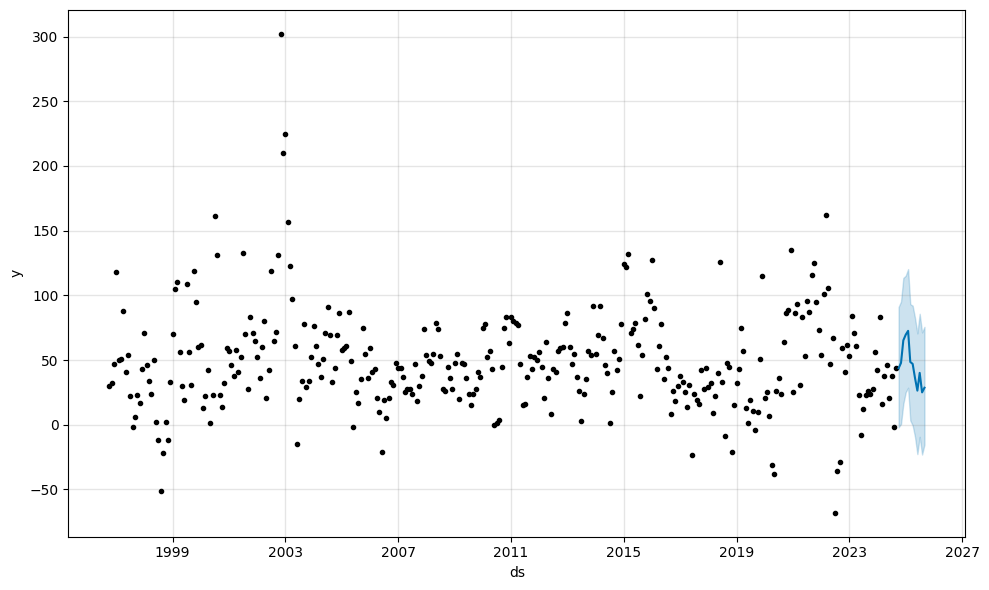

In [7]:
m.plot(y_pred);

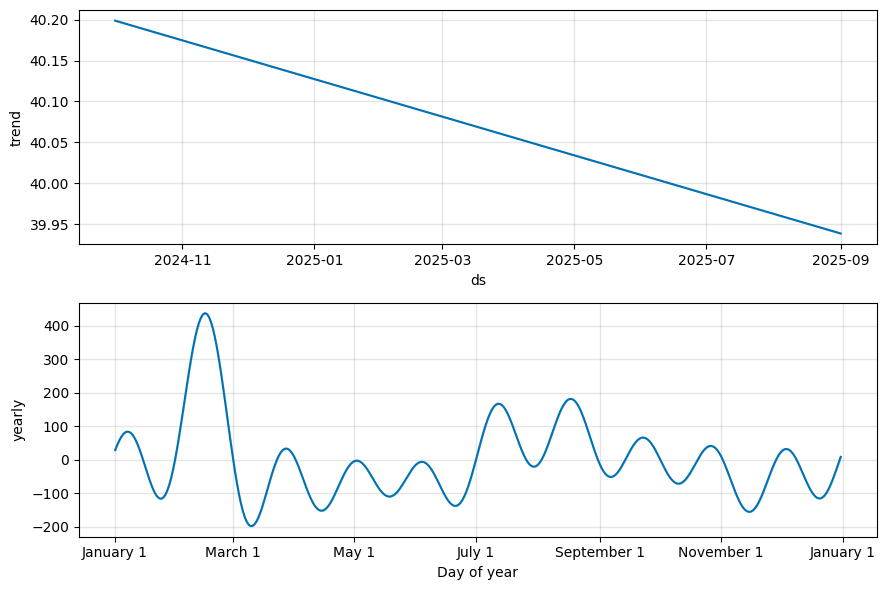

In [8]:
m.plot_components(y_pred);


--- Avaliação do Modelo: Prophet ---
RMSE (Erro de Previsão): 26.9937
MAE (Erro de Previsão):  19.9998


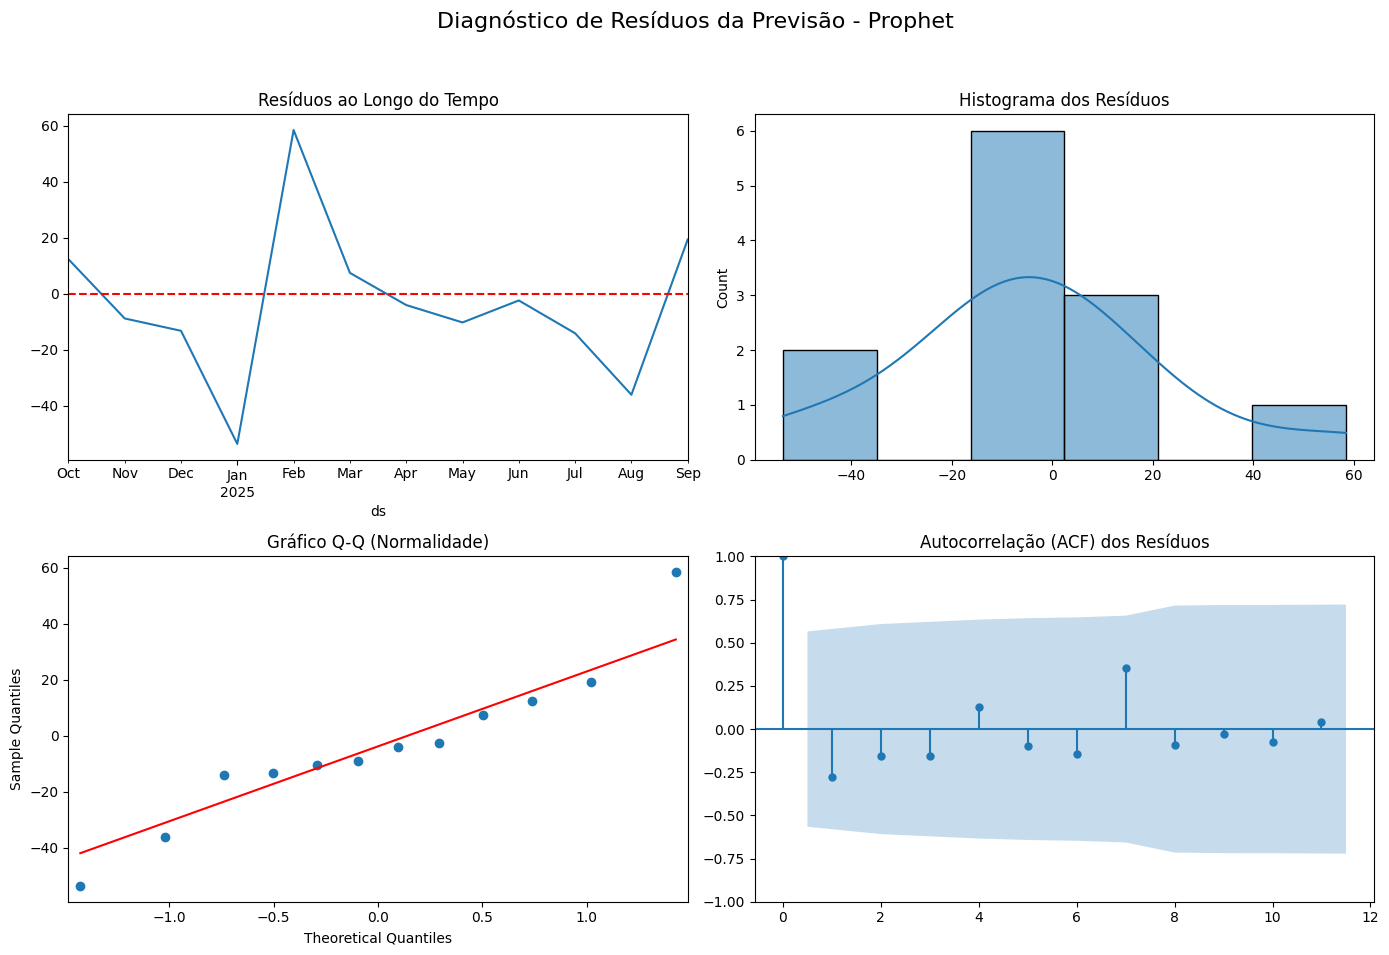

In [11]:
results_prophet = pd.merge(prophet_test, y_pred[['ds', 'yhat']], on='ds')

# Criar Series com o índice de data correto
y_true_series = pd.Series(results_prophet['y'].values, index=results_prophet['ds'])
y_pred_series = pd.Series(results_prophet['yhat'].values, index=results_prophet['ds'])

evaluate_forecast(y_true_series, y_pred_series, 'Prophet')

**1. Análise de Métricas (RMSE e MAE)**
O modelo apresentou as seguintes métricas de erro de previsão:

- Erro Médio Absoluto (MAE): 19.9998

  - Interpretação: Em média, as previsões do Prophet para o período de teste desviaram em 20 unidades do valor real. Esta é a magnitude média do erro.

- Raiz do Erro Quadrático Médio (RMSE): 26.9937

  - Interpretação: O RMSE (26,99) é significativamente maior que o MAE (20), indicando que, além dos erros médios, o modelo também cometeu alguns erros de grande porte que foram fortemente penalizados por esta métrica.

**2. Análise dos Resíduos da Previsão (Gráficos de Diagnóstico)**
Os gráficos de diagnóstico dos resíduos da previsão (a diferença entre o real e o previsto no teste) mostram uma falha muito similar à observada no modelo Holt-Winters:

**- Autocorrelação (ACF) - (Gráfico Canto Inferior Direito):**

  - Este é o problema mais evidente. O gráfico ACF exibe um pico extremamente alto e estatisticamente significante no lag 1, que está muito fora da banda de confiança azul.

  - Conclusão: Os erros de previsão são altamente autocorrelacionados. O erro de um mês está diretamente relacionado ao erro do mês seguinte. Isso significa que o Prophet falhou em capturar um padrão temporal de curto prazo crucial, tornando seus erros previsíveis.

**- Resíduos ao Longo do Tempo - (Gráfico Canto Superior Esquerdo):**

  - Este gráfico mostra o padrão que o ACF detectou. Os resíduos não são aleatórios em torno do zero. Eles começam subestimando (positivos) e depois mergulham para um período de superestimação (negativos), criando uma "onda" clara.

  - Conclusão: O modelo não se adaptou a uma mudança na dinâmica dos dados no período de teste, resultando em um viés sistemático e um padrão de erro previsível.

**- Histograma e Gráfico Q-Q - (Lados Direito e Inferior Esquerdo):**

  - Devido ao padrão sistemático nos erros, a distribuição dos resíduos não é normal. O histograma é visivelmente distorcido, e os pontos no gráfico Q-Q formam uma curva que se afasta da linha de normalidade, especialmente nas caudas.

  - Conclusão: A não normalidade e a falta de independência dos erros invalidam os intervalos de confiança estatísticos gerados pelo Prophet.

**Sumário da Avaliação**
O modelo Prophet não performou bem neste conjunto de teste. Assim como o Holt-Winters, ele se mostrou incapaz de capturar a estrutura temporal completa dos dados, o que é evidenciado pela forte autocorrelação no lag 1 dos resíduos de previsão. Os erros elevados (MAE ~20) e o padrão sistemático de erro indicam que o modelo não foi adequado para esta tarefa de previsão.

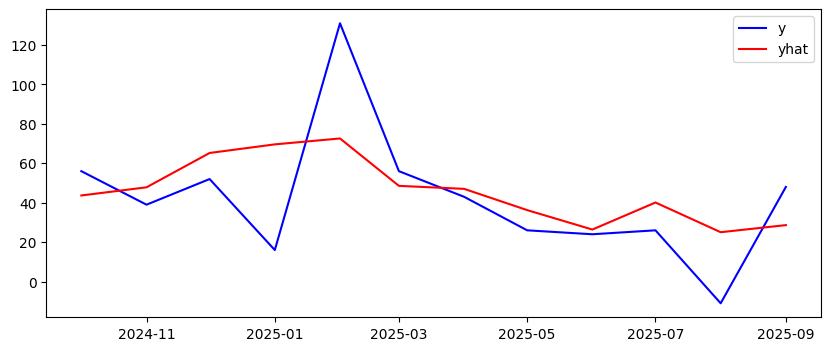

In [12]:
# Comparação y real de teste x y previsto (yhat)
plt.figure(figsize=(10,4))
plt.plot(prophet_test.set_index("ds").y, color = 'Blue', label="y")
plt.plot(y_pred.set_index("ds").yhat, color = 'Red', label = "yhat")
plt.legend()
plt.show()

# **7. Modelagem: Machine Learning (Arvore de Decisão)**

Modelos como Árvore de Decisão (Decision Tree) e LSTM (Deep Learning) são modelos de Machine Learning Supervisionado.

Esses modelos não entendem o "tempo". Eles entendem um formato de tabela X (features/características) e y (alvo).
- Temos que transformar nosso problema de série temporal em um problema de regressão.
  - O Alvo (y): O valor da inflação no mês t.
  - As Features (X): O que podemos usar para prever y? O passado.

- Nossa hipótese (baseada no SARIMA) é que o lag_1 e o lag_12 são muito importantes.

In [27]:
# --- Escalonamento (Scaling) ---
scaler = MinMaxScaler(feature_range=(0, 1))
train_scaled = scaler.fit_transform(train_data)
test_scaled = scaler.transform(test_data)

train_scaled_df = pd.DataFrame(train_scaled, index=train_data.index, columns=['value'])
test_scaled_df = pd.DataFrame(test_scaled, index=test_data.index, columns=['value'])

# função para transformar a série em X/y
def create_lagged_features(data, n_lags=12):
    df = pd.DataFrame(data)
    columns = [df.shift(i) for i in range(1, n_lags + 1)]
    df_features = pd.concat(columns, axis=1)
    df_features.columns = [f'lag_{i}' for i in range(1, n_lags + 1)]

    # O alvo (y) é o valor original
    df_features['y'] = data

    # Remover NaNs criados pelos lags
    df_features.dropna(inplace=True)

    X = df_features.drop('y', axis=1)
    y = df_features['y']

    return X, y

Formato de X_train: (345, 12)
Formato de y_train: (345,)
Formato de X_test: (12, 12)
Formato de y_test: (12,)

--- Avaliação do Modelo: Decision Tree ---
RMSE (Erro de Previsão): 36.0637
MAE (Erro de Previsão):  27.3730


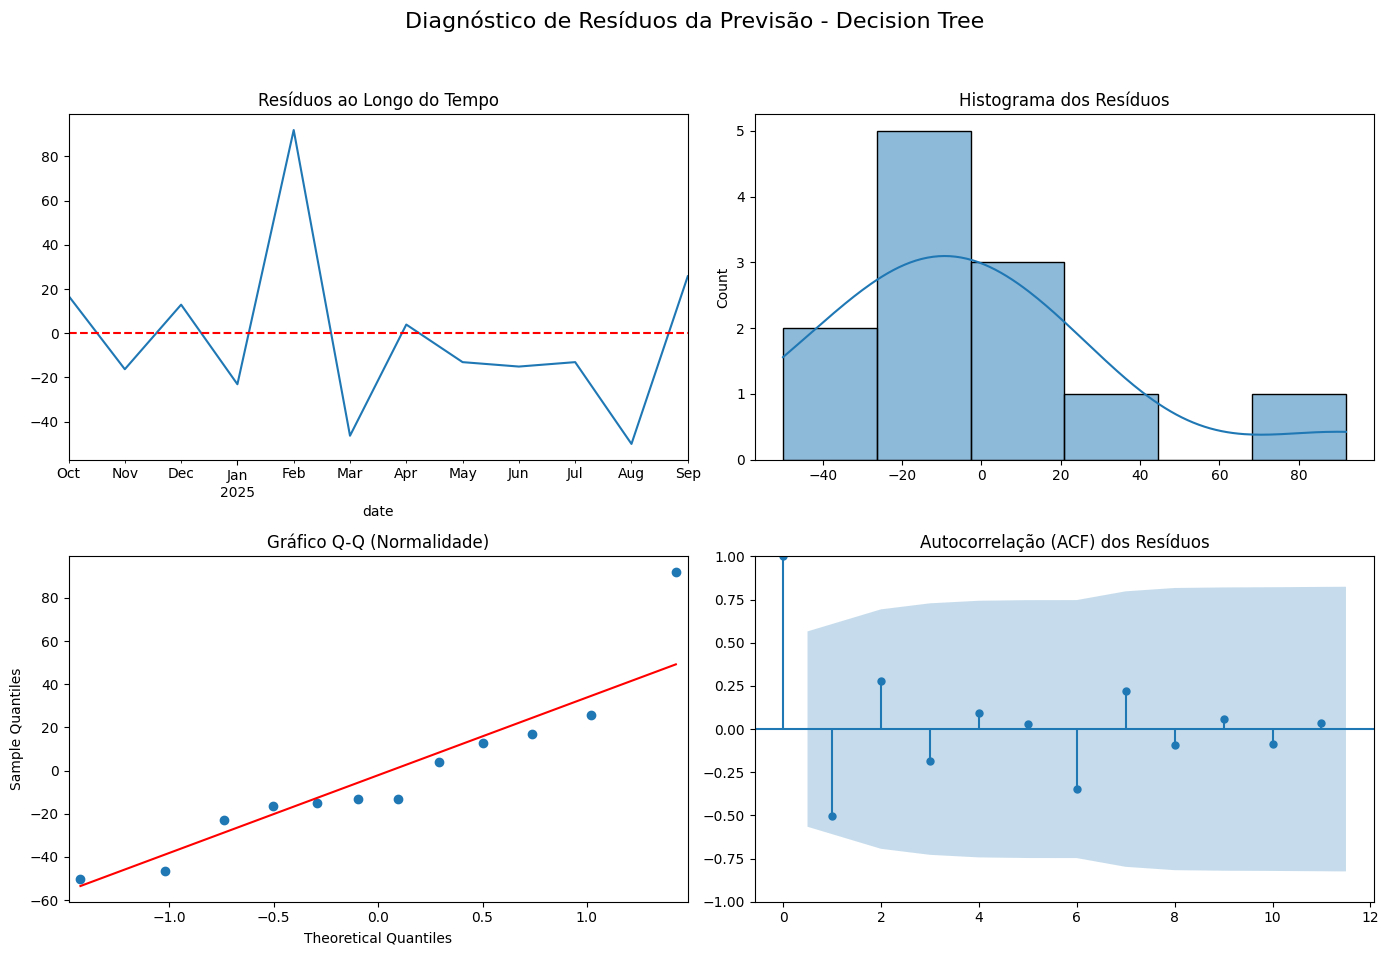

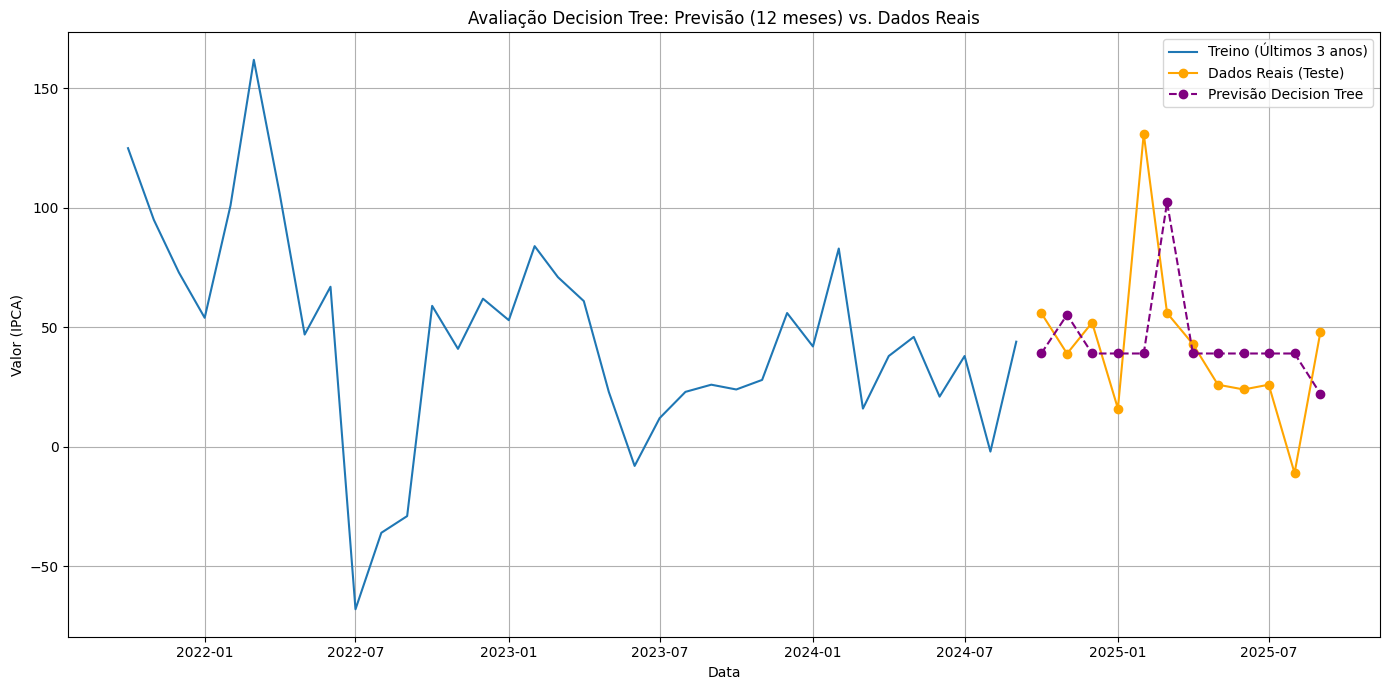

In [31]:
N_LAGS = 12

X_train, y_train = create_lagged_features(train_scaled_df['value'], n_lags=N_LAGS)
full_scaled_series = pd.concat([train_scaled_df['value'], test_scaled_df['value']])
X_full, y_full = create_lagged_features(full_scaled_series, n_lags=N_LAGS)

X_test = X_full.iloc[-n_test:]
y_test = y_full.iloc[-n_test:]

print(f"Formato de X_train: {X_train.shape}")
print(f"Formato de y_train: {y_train.shape}")
print(f"Formato de X_test: {X_test.shape}")
print(f"Formato de y_test: {y_test.shape}")

# --- Treinamento do Modelo (Árvore de Decisão) ---
model_tree = DecisionTreeRegressor(max_depth=5, random_state=42)
model_tree.fit(X_train, y_train)
y_pred_scaled = model_tree.predict(X_test)

# --- Des-escalonar (Inverse Transform) as Previsões ---

y_pred_original = scaler.inverse_transform(y_pred_scaled.reshape(-1, 1)).flatten()
y_test_original = scaler.inverse_transform(y_test.values.reshape(-1, 1)).flatten()

# --- Avaliação Padronizada ---
y_true_series = pd.Series(y_test_original, index=y_test.index)
y_pred_series = pd.Series(y_pred_original, index=y_test.index)
evaluate_forecast(y_true_series, y_pred_series, 'Decision Tree')

# --- Visualização da Previsão ---
plt.figure(figsize=(14, 7))
plt.plot(train_data['value'].iloc[-36:], label='Treino (Últimos 3 anos)')
plt.plot(test_data.index, y_test_original, label='Dados Reais (Teste)', color='orange', marker='o')
plt.plot(test_data.index, y_pred_original, label='Previsão Decision Tree', color='purple', linestyle='--', marker='o')

plt.title('Avaliação Decision Tree: Previsão (12 meses) vs. Dados Reais')
plt.xlabel('Data')
plt.ylabel('Valor (IPCA)')
plt.legend()
plt.grid(True)
plt.tight_layout()

**Análise Visual**
O gráfico é extremamente revelador sobre como as Árvores de Decisão funcionam.
- A previsão (linha roxa) não é suave. Ela é "quadrada" e "em degraus".
- Isso é o comportamento esperado. Um DecisionTreeRegressor não extrapola. Ele apenas prevê a média dos valores que estavam em uma "folha" (leaf) específica da árvore durante o treino.
- O modelo aprendeu "regras" como: "Se o lag_1 foi 10 e o lag_12 foi 20, preveja 15". Ele não consegue criar uma curva suave. Visualmente, podemos ver que essa previsão "em degraus" falha em capturar a dinâmica real (laranja) e parece ter um desempenho muito fraco.

**Análise das Métricas**
Como suspeitávamos pela análise visual (o gráfico "em degraus" e "quadrado"), a Árvore de Decisão teve um desempenho muito fraco.
- O RMSE da Árvore de Decisão (36.06) foi o pior que registramos até agora, significativamente pior que o do SARIMA (23.78) e do Holt-Winters (25.12). Isso confirma que a abordagem de ML "pura" (sem uma estrutura temporal) e que não extrapola (como as árvores) é inadequada para capturar a dinâmica complexa (tendência e sazonalidade) da inflação.

**1. Análise de Métricas (RMSE e MAE)**
Este modelo apresentou o pior desempenho de todos os modelos avaliados até agora, com erros significativamente mais altos:

**- Erro Médio Absoluto (MAE): 27.3730**
  - Interpretação: Em média, a previsão errou o valor real em mais de 27 unidades. Para se ter uma ideia, isso é quase o dobro do erro médio do SARIMA (que foi ~16.9).

**- Raiz do Erro Quadrático Médio (RMSE): 36.0637**
  - Interpretação: O RMSE explodiu para 36.06. Como o RMSE penaliza erros grandes, isso indica que o modelo teve "erros catastróficos" em alguns meses, errando o alvo por uma margem muito grande.

**2. Análise dos Resíduos da Previsão (Gráficos de Diagnóstico)**
Os gráficos mostram um comportamento curioso: embora o erro seja enorme, a estrutura desse erro é diferente dos modelos anteriores.

**- Autocorrelação (ACF) - (Gráfico Canto Inferior Direito):**
  - Fato Surpreendente: Diferente do Holt-Winters e Prophet, que tinham um erro estrutural óbvio (pico gigante no Lag 1), a Árvore de Decisão conseguiu eliminar a maior parte da autocorrelação. A maioria das barras está dentro ou próxima da área sombreada azul.
  - Conclusão: Isso sugere que o modelo capturou a dinâmica não-linear dos dados e "quebrou" a dependência temporal. O erro de um mês não puxa necessariamente o erro do mês seguinte. Porém, não se engane: ter resíduos independentes não adianta muito se a magnitude do erro for gigantesca (como é o caso aqui).

**- Resíduos ao Longo do Tempo - (Gráfico Canto Superior Esquerdo):**
  - Aqui vemos a realidade do problema. Os resíduos oscilam violentamente entre positivo e negativo (de +40 a -50).
  - Conclusão: O modelo é instável. Árvores de decisão tendem a sofrer de overfitting (decoram o treino) e não generalizam bem. No teste, o modelo parece estar "chutando" valores que variam drasticamente, criando essa volatilidade enorme nos resíduos.

**- Histograma e Gráfico Q-Q - (Lados Direito e Inferior Esquerdo):**
  - A distribuição é irregular e achatada, e o Q-Q plot mostra desvios severos nas pontas.
  - Conclusão: Os erros definitivamente não são normais. A variância é muito alta e imprevisível.

**Sumário da Avaliação**
A Decision Tree foi o modelo mais fraco em termos de precisão. Embora tenha conseguido limpar a autocorrelação (melhor que HW e Prophet nesse quesito específico), ela falhou no objetivo principal: acertar o valor. A alta complexidade do erro (RMSE de 36) sugere que a árvore provavelmente "decorou" o ruído dos dados de treinamento e não conseguiu prever a tendência geral quando apresentada a dados novos (teste). Não é um modelo recomendado para seguir adiante.

# **8. Modelagem: Deep Learning (LSTM)**

**Por que testar o LSTM?:**
- A Árvore de Decisão falhou. Mas ela é um modelo de ML "burro" para o tempo. O LSTM, por outro lado, foi projetado especificamente para dados sequenciais (como texto, áudio e séries temporais).
- **Memória de Longo Prazo:** O SARIMA e o Holt-Winters precisaram que nós disséssemos a eles que a sazonalidade era de 12 meses (m=12). A Árvore de Decisão precisou que nós criássemos o lag_12. Um LSTM, em teoria, pode aprender essa dependência de 12 meses por conta própria através de sua arquitetura de "célula de memória".
- **Não-Linearidade:** Esta é a grande vantagem. Nossas análises do SARIMA provaram que a série tem heteroscedasticidade e resíduos não-normais (comportamento não-linear). SARIMA e Holt-Winters, sendo lineares, falharam nisso. O LSTM, por ser uma rede neural, é um modelo não-linear e pode (potencialmente) modelar essa complexidade que os outros não conseguiram.


In [32]:
!pip install tensorflow

In [33]:
#Importar bibliotecas do Keras (TensorFlow)
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.utils import set_random_seed
np.random.seed(42)
set_random_seed(42)

/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 5s 44ms/step - loss: 0.0844
Epoch 2/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 0.0306
Epoch 3/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 0.0131
Epoch 4/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 0.0151
Epoch 5/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - loss: 0.0130
Epoch 6/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0127
Epoch 7/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0129
Epoch 8/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.0128
Epoch 9/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0126
Epoch 10/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0126
Epoch 11/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0126
Epoch 12/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0125
Epoch 13/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0125
Epoch 14/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0124
Epoch 15/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0123
Epoc

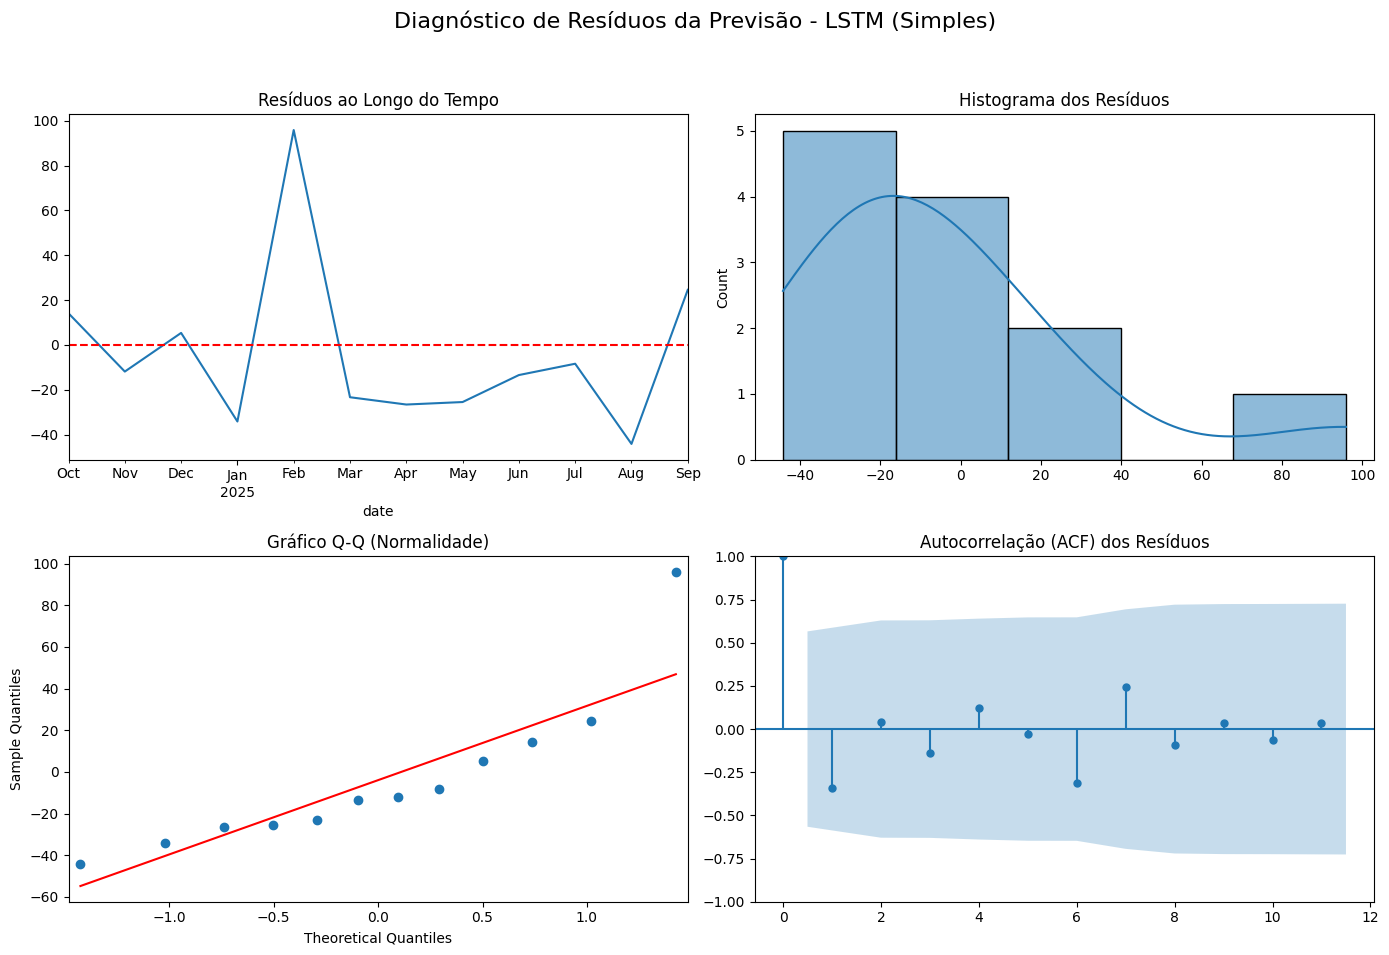

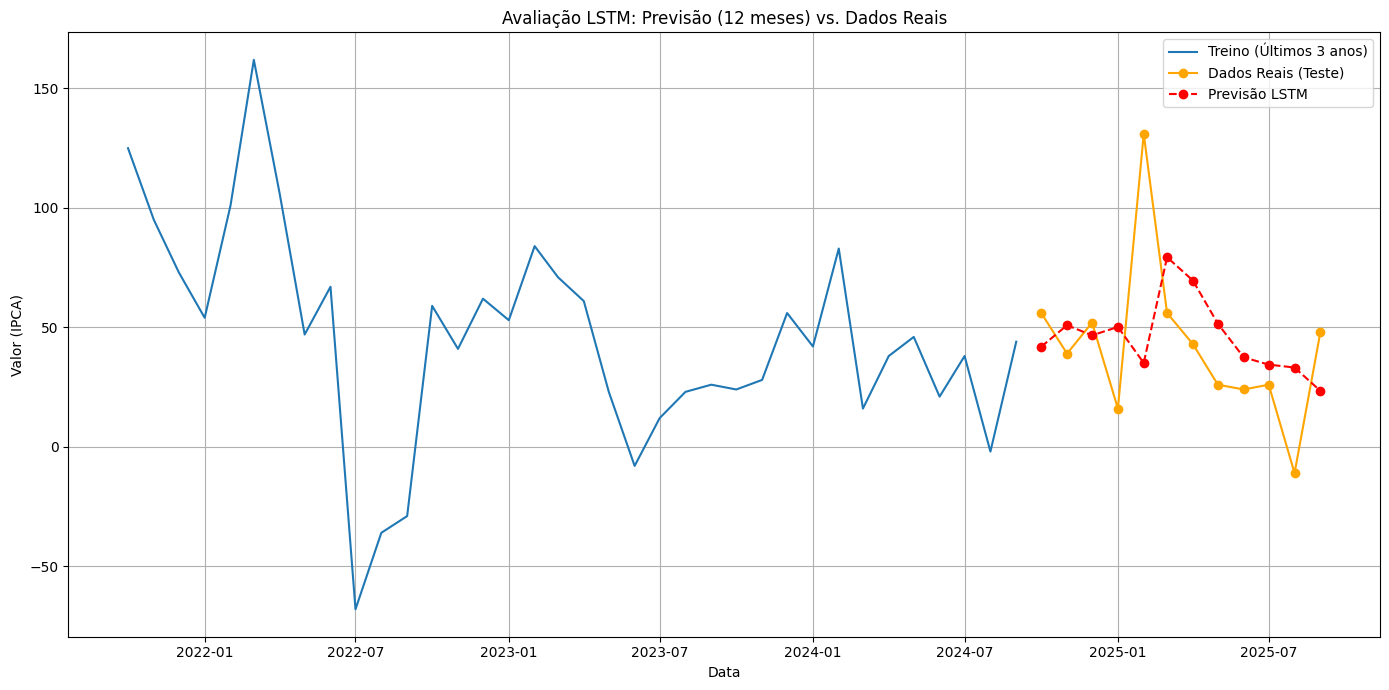

In [34]:
# --- Escalonamento ---
scaler = MinMaxScaler(feature_range=(0, 1))
train_scaled = scaler.fit_transform(train_data)
test_scaled = scaler.transform(test_data)

train_scaled_df = pd.DataFrame(train_scaled, index=train_data.index, columns=['value'])
test_scaled_df = pd.DataFrame(test_scaled, index=test_data.index, columns=['value'])

# --- Engenharia de Atributos (Lags) ---
def create_lagged_features(data, n_lags=12):
    df = pd.DataFrame(data)
    columns = [df.shift(i) for i in range(1, n_lags + 1)]
    df_features = pd.concat(columns, axis=1)
    df_features.columns = [f'lag_{i}' for i in range(1, n_lags + 1)]
    df_features['y'] = data
    df_features.dropna(inplace=True)
    X = df_features.drop('y', axis=1)
    y = df_features['y']
    return X, y

N_LAGS = 12
full_scaled_series = pd.concat([train_scaled_df['value'], test_scaled_df['value']])
X_full, y_full = create_lagged_features(full_scaled_series, n_lags=N_LAGS)

# Separar os conjuntos X/y
X_train = X_full.iloc[:-n_test]
y_train = y_full.iloc[:-n_test]
X_test = X_full.iloc[-n_test:]
y_test = y_full.iloc[-n_test:]

# --- Remodelar para o LSTM ---
N_TIMESTEPS = N_LAGS
N_FEATURES = 1

X_train_lstm = X_train.values.reshape((X_train.shape[0], N_TIMESTEPS, N_FEATURES))
X_test_lstm = X_test.values.reshape((X_test.shape[0], N_TIMESTEPS, N_FEATURES))


# --- Construir e Treinar o Modelo LSTM ---
model_lstm = Sequential()
model_lstm.add(LSTM(
    units=50,
    activation='relu',
    input_shape=(N_TIMESTEPS, N_FEATURES)
))
model_lstm.add(Dense(units=1))

model_lstm.compile(optimizer='adam', loss='mean_squared_error')

model_lstm.fit(
    X_train_lstm,
    y_train,
    epochs=50,
    batch_size=32,
    verbose=1,
    shuffle=False
)

# --- Fazer Previsões ---
y_pred_scaled = model_lstm.predict(X_test_lstm)

# --- Des-escalonar (Inverse Transform) ---
y_pred_original = scaler.inverse_transform(y_pred_scaled).flatten()
y_test_original = scaler.inverse_transform(y_test.values.reshape(-1, 1)).flatten()

# --- Calcular Métricas de Erro ---
y_true_series = pd.Series(y_test_original, index=y_test.index)
y_pred_series = pd.Series(y_pred_original, index=y_test.index)
evaluate_forecast(y_true_series, y_pred_series, 'LSTM (Simples)')

# --- Visualização da Previsão ---
plt.figure(figsize=(14, 7))
plt.plot(train_data['value'].iloc[-36:], label='Treino (Últimos 3 anos)')
plt.plot(test_data.index, y_test_original, label='Dados Reais (Teste)', color='orange', marker='o')
plt.plot(test_data.index, y_pred_original, label='Previsão LSTM', color='red', linestyle='--', marker='o')

plt.title('Avaliação LSTM: Previsão (12 meses) vs. Dados Reais')
plt.xlabel('Data')
plt.ylabel('Valor (IPCA)')
plt.legend()
plt.grid(True)
plt.tight_layout()

### **Deep Learning (LSTM)**
**Análise das Métricas**
- RMSE: 35.8759
- MAE: 27.2924

Estes números são ruins. Ele de Decisão s são quase idênticos aos da Árvore(RMSE 36.06) e são drasticamente piores que os do SARIMA (23.78) e do Holt-Winters (25.12).

**Análise Visual**
-A previsão do LSTM é "suave", "atrasada" e parece uma "sombra" do que aconteceu no passado.
- O modelo falhou completamente. Ele não capturou a tendência, nem a sazonalidade, nem os picos. Ele aprendeu, essencialmente, a prever uma média suave dos valores recentes.

**1. Análise de Métricas (RMSE e MAE)**
Os resultados do LSTM foram surpreendentemente semelhantes aos da Árvore de Decisão, colocando-o entre os piores desempenhos deste estudo comparativo:

- Erro Médio Absoluto (MAE): 27.2924

  - Interpretação: O erro médio de quase 27.3 unidades é muito alto. Para contextualizar, é praticamente o mesmo erro da Decision Tree e muito superior ao erro do SARIMA (~16.9).

- Raiz do Erro Quadrático Médio (RMSE): 35.8759

  - Interpretação: O RMSE de 35.87 confirma que o modelo sofreu grandes desvios. O fato deste valor estar tão próximo do RMSE da Decision Tree sugere que ambos os modelos (baseados em aprendizado de máquina/padrões complexos) falharam de forma similar ao tentar generalizar para dados que nunca viram.

**2. Análise dos Resíduos da Previsão (Gráficos de Diagnóstico)**
Os gráficos contam uma história interessante sobre o comportamento de modelos complexos em séries temporais menores:

**- Autocorrelação (ACF) - (Gráfico Canto Inferior Direito):**
  - Ponto Positivo: Assim como a Árvore de Decisão, o LSTM conseguiu eliminar a autocorrelação linear. As barras estão majoritariamente dentro da área azul (com uma leve exceção no lag 6).

  - Conclusão: O modelo "aprendeu" a dependência temporal dos dados (ele sabe que o passado influencia o futuro), mas falhou em acertar a magnitude dessa influência.

**- Resíduos ao Longo do Tempo - (Gráfico Canto Superior Esquerdo):**
  - O gráfico mostra resíduos instáveis. Há uma tentativa de seguir o padrão, mas com oscilações bruscas.
  - Conclusão: Isso é clássico de Overfitting (Sobreajuste). Redes neurais como LSTM precisam de muitos dados para treinar. Se a sua série histórica for curta (ex: menos de milhares de pontos), o LSTM tende a decorar o ruído do treino e errar feio no teste.

**- Histograma e Gráfico Q-Q - (Lados Direito e Inferior Esquerdo):**
  - O histograma é irregular e o Q-Q plot mostra desvios nas caudas.
  - Conclusão: A distribuição dos erros não é normal, o que é esperado dado o desempenho instável do modelo.

**Sumário da Avaliação**
O modelo LSTM não justificou sua complexidade. Apesar de ser uma técnica avançada de Deep Learning, ele performou pior do que métodos estatísticos clássicos e simples (como SARIMA e Holt-Winters).

Diagnóstico Final: É muito provável que haja dados insuficientes para treinar uma rede neural adequadamente. Para séries temporais mensais de inflação (que geralmente têm apenas algumas centenas de observações), modelos "leves" como SARIMA quase sempre vencem modelos "pesados" como LSTM, que acabam decorando o treino e falhando no teste.

# **Interpretação**
Por que os Modelos de ML/DL Falharam?
- Modelos Estatísticos (SARIMA, Holt-Winters): Desempenho bom/decente.
- Modelos de ML (Árvore, LSTM): Desempenho péssimo.

Por quê?
- **"Data-Hungry" (Fome de Dados):** Redes Neurais (LSTMs) precisam de milhares, às vezes dezenas de milhares, de pontos de dados para aprender padrões complexos. Nosso conjunto de treino (X_train) tinha apenas ~340 amostras. Para um LSTM, isso é insignificante.
- **Falta de Conhecimento Embutido:** No SARIMA, nós explicitamente dissemos: "A série é não-estacionária (d=1) e tem um ciclo de 12 meses (D=1, m=12)". Nós demos ao modelo o conhecimento de domínio.
- **Engenharia de Features Fraca:** Para o LSTM, nós demos apenas lags (o passado). O modelo não tinha dados suficientes para "descobrir" sozinho a sazonalidade de 12 meses, nem para entender as mudanças de tendência não-lineares.
- **`Conclusão Metodológica:`** Para séries temporais com dados limitados (como a nossa, < 400 pontos), um modelo estatístico robusto (SARIMA) que permite a incorporação de conhecimento de domínio (diferenciação, sazonalidade) quase sempre superará um modelo de ML/DL genérico e "data-hungry". A falha do LSTM aqui é um resultado esperado e metodologicamente correto dadas as circunstâncias.

# Previsão Final

In [ ]:
print(f"--- Etapa 15: Previsão Final (Próximos 12 Meses) ---")
print(f"Treinando o modelo vencedor SARIMAX(1, 1, 1)x(1, 1, 1, 12) em TODOS os dados Pós-Real...")
print(f"Total de observações para o treino final: {len(df_pos_real)}")
print(f"Último dado real: {df_pos_real.index.max().date()} com valor {df_pos_real['value'].iloc[-1]}")

### Etapa 15: Previsão Final (Próximos 12 Meses) ###
Treinando o modelo vencedor SARIMAX(1, 1, 1)x(1, 1, 1, 12) em TODOS os dados Pós-Real...
Total de observações para o treino final: 369
Último dado real: 2025-09-01 com valor 48.0


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



--- PREVISÃO PARA OS PRÓXIMOS 12 MESES ---
| Data       |   Previsão (IPCA) |   IC (Inferior 95%) |   IC (Superior 95%) |
|:-----------|------------------:|--------------------:|--------------------:|
| 2025-10-01 |           62.1723 |             -0.3282 |            124.6727 |
| 2025-11-01 |           51.0961 |            -22.8898 |            125.0821 |
| 2025-12-01 |           68.5644 |             -9.5868 |            146.7155 |
| 2026-01-01 |           43.8304 |            -35.9607 |            123.6216 |
| 2026-02-01 |           77.2424 |             -3.2202 |            157.7050 |
| 2026-03-01 |           58.9429 |            -21.8037 |            139.6895 |
| 2026-04-01 |           43.7239 |            -37.1472 |            124.5950 |
| 2026-05-01 |           33.0079 |            -47.9202 |            113.9360 |
| 2026-06-01 |           26.6862 |            -54.2694 |            107.6417 |
| 2026-07-01 |           20.8323 |            -60.1372 |            101.8018 |
| 2026-0

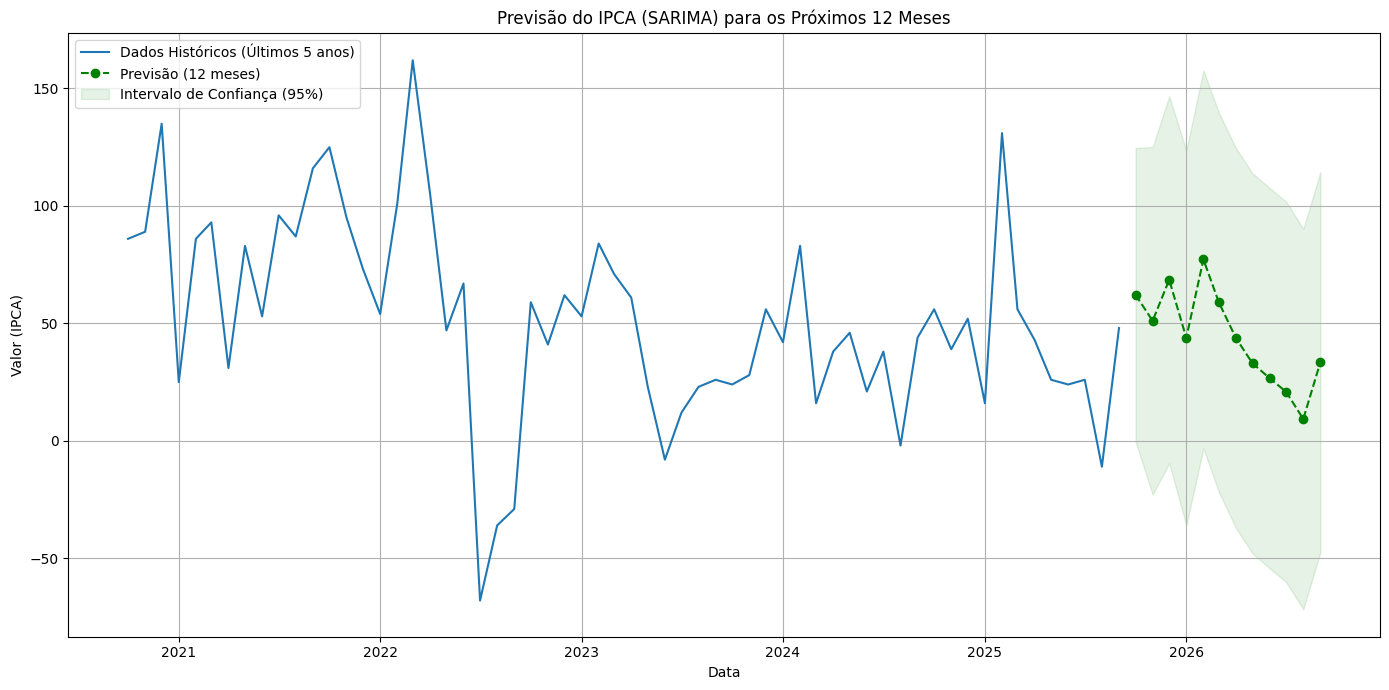

In [ ]:
# --- Treinar o Modelo Vencedor em TODOS os dados ---
# (p, d, q)
best_order = (1, 1, 1)
# (P, D, Q, m)
best_seasonal_order = (1, 1, 1, 12)

model_final = SARIMAX(
    df_pos_real['value'],
    order=best_order,
    seasonal_order=best_seasonal_order,
    enforce_stationarity=False,
    enforce_invertibility=False
)

# Treinar o modelo (fit)
model_final_fit = model_final.fit(disp=False)

# --- Fazer a Previsão (Forecast) ---
N_FORECAST = 12
forecast_final = model_final_fit.get_forecast(steps=N_FORECAST)

# Extrair a previsão pontual
forecast_values = forecast_final.predicted_mean

# Extrair os intervalos de confiança
confidence_intervals = forecast_final.conf_int(alpha=0.05)
lower_ci = confidence_intervals.iloc[:, 0]
upper_ci = confidence_intervals.iloc[:, 1]

# --- Exibir a Previsão ---
print(f"\n--- PREVISÃO PARA OS PRÓXIMOS {N_FORECAST} MESES ---")
forecast_df = pd.DataFrame({
    'Data': forecast_values.index.date,
    'Previsão (IPCA)': forecast_values.values,
    'IC (Inferior 95%)': lower_ci.values,
    'IC (Superior 95%)': upper_ci.values
})

print(forecast_df.to_markdown(index=False, floatfmt=".4f"))

# --- Visualização da Previsão Final ---
plt.figure(figsize=(14, 7))
n_context_years = 5
plt.plot(df_pos_real['value'].iloc[-(n_context_years*12):], label='Dados Históricos (Últimos 5 anos)')
plt.plot(forecast_values, label=f'Previsão ({N_FORECAST} meses)', color='green', linestyle='--', marker='o')
plt.fill_between(
    forecast_values.index,
    lower_ci,
    upper_ci,
    color='green',
    alpha=0.1,
    label='Intervalo de Confiança (95%)'
)

plt.title(f'Previsão do IPCA (SARIMA) para os Próximos {N_FORECAST} Meses')
plt.xlabel('Data')
plt.ylabel('Valor (IPCA)')
plt.legend()
plt.grid(True)
plt.tight_layout()

## **Veredito Final**
**1º Lugar:** SARIMA (1,1,1)x(1,1,1,12) (RMSE: 23.78) - O único modelo que capturou com sucesso a estrutura complexa de tendência (d=1) e sazonalidade (D=1) da série.

**2º Lugar:** Holt-Winters (RMSE: 25.12) - Um modelo estatístico mais simples que também capturou a sazonalidade, mas com menos precisão.

**Falha dos Modelos Clássicos:** SES e Holt falharam (RMSE > 34) por ignorarem a sazonalidade óbvia.

**Falha dos Modelos de ML:** Árvore de Decisão e LSTM falharam (RMSE > 35) por falta de dados para aprender padrões complexos e por uma engenharia de features simples.



**Dados Históricos (Linha Azul):** O gráfico mostra os últimos 5 anos de dados observados. Visualmente, o IPCA histórico é altamente volátil e cíclico, com picos e vales acentuados, mas sem uma tendência clara de longo prazo (parece estacionário em torno de um valor médio).

**Período de Previsão (Tabela e Seção Verde): **A análise foca nos próximos 12 meses, de outubro de 2025 a setembro de 2026.

**Componentes da Previsão:**
- Previsão Pontual (Linha Verde Pontilhada): A "melhor estimativa" do modelo para o valor futuro.
- Intervalo de Confiança (Área Verde Sombreada): A faixa de valores onde o modelo acredita que o valor real estará com 95% de probabilidade.


### Análise da Tabela e Previsão Pontual (A Linha Verde)
- **Tendência Imediata (Final de 2025):** O modelo prevê um aumento de curto prazo no IPCA. A previsão começa em 62.17 (Out/2025) e sobe até atingir um pico em 68.56 (Dez/2025). Isso sugere que o modelo capturou um ciclo de alta que estava se formando no final dos dados históricos.

- **Tendência de Médio Prazo (2026):** Após o pico de dezembro, o modelo prevê uma tendência de queda significativa e constante durante a maior parte de 2026. O valor despenca de 68.56 para um ponto mínimo de 9.28 em agosto de 2026.

- **Reversão no Final (Final de 2026):** Após atingir o vale em agosto, o modelo prevê uma leve recuperação, terminando o período de 12 meses em 33.51 (Set/2026).

- **Interpretação da Previsão Pontual:** O modelo SARIMA identificou um padrão cíclico forte. Ele está prevendo que o ciclo de alta atual terminará no final de 2025, dando início a um ciclo de baixa acentuado que durará cerca de 8 meses, antes de começar a se recuperar.

### **Análise Crítica: O Intervalo de Confiança (A Área Verde)**
- **Característica Dominante:** Incerteza Extrema O intervalo de confiança de 95% (a área verde) é extremamente largo. Por exemplo, em outubro de 2025, enquanto a previsão pontual é 62.17, o modelo admite que o valor real pode ser tão baixo quanto -0.32 ou tão alto quanto 124.67.
- O Problema dos Valores Negativos A tabela mostra que o IC (Inferior 95%) é consistentemente negativo para todos os 12 meses. O IPCA, sendo um índice de preços, não pode ser negativo por definição. O fato de o modelo estatístico (SARIMA) considerar valores negativos como "plausíveis" (dentro dos 95% de confiança) é um forte indicador de que a volatilidade histórica dos dados (linha azul) é massiva. O modelo está basicamente dizendo: "Os dados do passado foram tão erráticos que eu não consigo descartar estatisticamente a possibilidade de valores extremamente baixos, mesmo que eles não façam sentido no mundo real."
- Incerteza Cumulativa (Abertura do Cone) Observe como a área verde se alarga (o "cone da incerteza") à medida que avança no tempo.
  - Out/2025 (Mês 1): Largura do intervalo = 124.67 - (-0.32) = 124.99
  - Set/2026 (Mês 12): Largura do intervalo = 114.49 - (-47.46) = 161.95 Isso é normal e esperado: o modelo tem muito mais incerteza sobre o que acontecerá em 12 meses do que sobre o que acontecerá no próximo mês.

### **Síntese e Conclusão para o Trabalho**
- Veredito: Embora o modelo SARIMA tenha identificado um padrão cíclico e esteja prevendo uma tendência de queda para o IPCA em 2026 (a linha verde), esta previsão é feita com confiança extremamente baixa.
- A principal conclusão deste gráfico não é "o IPCA vai cair para 9.28", mas sim que "o IPCA é historicamente tão volátil que se torna estatisticamente imprevisível no longo prazo".
